# INIT

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Imports

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
inline_rc = dict(mpl.rcParams)
import os
import glob

/Users/tomdenottelander/miniconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  """


### Figure parameters

In [717]:
mpl.rcParams['figure.titlesize'] = 20
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 15
figsize = [30, 15]

### Methods

#### F: Filecheck

In [3]:
def FileCheck(fn):
    try:
        open(fn, "r")
        return True
    except IOError:
#         print("Error: File does not appear to exist.")
        return False

#### F: getReps( )

In [4]:
def getReps(folder):
    fn = folder + "experiment.json"
    print(fn)
#     if FileCheck(fn):
#         with open (fn) as json_file:
#             try:
#                 experimentInfo = json.load(json_file)
#                 return experimentInfo["repetitions"]
#             except:
#                 pass

    i = 0
    while(True):
        fn = glob.glob(folder + "*O_info" + str(i) + ".json")
        if len(fn) is 0:
#         if not FileCheck(fn[0]):
            return i
        i = i + 1 

#### F: findMaxEvalsLength( )

In [5]:
def findMaxEvalsLength(folder, evalType, reps):
    maxEvalsLength = 0
    for i in range(reps):
        fn = folder + "MO_info" + str(i) + ".json"
        with open(fn) as json_file:
            data = json.load(json_file)
            maxEvalsLength = max(maxEvalsLength, len(data["changes_on_interval"][evalType]["evals"]))
    return maxEvalsLength

#### Load benchmarks into global variables

In [908]:
with open("../benchmarks/ark8/ark8.json") as json_file:
    benchmark_data_c10 = json.load(json_file)
with open("../benchmarks/ark7/ark7.json") as json_file:
    benchmark_data_c100 = json.load(json_file)

In [912]:
# print(list(benchmark_data_c10.keys())[:10])

{'val_acc': 91.65}


In [916]:
with open("../benchmarks/ark7/ark7_original.json") as json_file:
    benchmark_data_c100_raw = json.load(json_file)
with open("../benchmarks/ark8/ark8_original.json") as json_file:
    benchmark_data_c10_raw = json.load(json_file)

In [973]:
print (benchmark_data_c10_raw["I1I1221I121121"])

{'test_acc': 91.29, 'MMACs': 128.15, 'val_acc': 91.65, 'Params': 2475082}


In [999]:
best_test_acc = -1
data = benchmark_data_c100_raw
for genotype in data:
    if len(genotype) is 14:
        best_test_acc = max(best_test_acc, data[genotype]['test_acc'])
print(best_test_acc)

70.51


#### F: getTestAcc( )

In [1153]:
def getTestAcc(genotypes, benchmark_data):
    test_accuracies = np.zeros(len(genotypes))
    for i, g in enumerate(genotypes):
        test_acc_single = benchmark_data[g.replace("0", "I")]["test_acc"] * 0.01
        test_accuracies[i] = test_acc_single
    return test_accuracies

In [1096]:
def filterDominatedSolutions(np_archive):
        n = np_archive.shape[0]
        toInclude = np.ones(n, dtype=bool)
        for i in range(n):
            f = np_archive[i]
            for j in range(n):
                if (np_archive[j,0] > f[0] and np_archive[j,1] >= f[1]) or (np_archive[j,0] >= f[0] and np_archive[j,1] > f[1]):
#                     print(np_archive[j,:], ">", f)
                    toInclude[i] = 0
                    break
#         print(toInclude)
#         print(np_archive)
#         print(np_archive[toInclude,:])
        return (np_archive[toInclude], np_archive[np.invert(toInclude)])
    

#### F: generateMOSummaryFiles( )

In [6]:
def generateMOSummaryFiles(folder):
    reps = getReps(folder)
    print("reps", reps)
    datapoints = 200
    
    changes_on_interval = {}
    
        
    for evalType in ["unique_evals", "total_evals", "network_unique_evals"]:  
        evals = []
        np_avg_dist = np.zeros([reps, datapoints])
        np_max_dist = np.zeros([reps, datapoints])
        np_paretopointsfound = np.zeros([reps, datapoints])
        
        for i in range(reps):
            fn = folder + "MO_info" + str(i) + ".json"
            with open(fn) as json_file:
                data = json.load(json_file)
                data = data["changes_on_interval"][evalType]
                
                np_avg_dist[i, :len(data["avg_dist"])] = data["avg_dist"]
                np_avg_dist[i, len(data["avg_dist"]):] = data["avg_dist"][-1] # Fill the rest with the last recorded distance value
                np_max_dist[i, :len(data["max_dist"])] = data["max_dist"]
                np_max_dist[i, len(data["max_dist"]):] = data["max_dist"][-1] # Fill the rest with the last recorded distance value
                np_paretopointsfound[i, :len(data["pareto_points_found"])] = data["pareto_points_found"]
                np_paretopointsfound[i, len(data["pareto_points_found"]):] = data["pareto_points_found"][-1]

                if len(data["evals"]) > len(evals):
                    evals = data["evals"]
        
        until = len(evals)
        np_avg_dist = np_avg_dist[:, :until]
        np_max_dist = np_max_dist[:, :until]
        np_paretopointsfound = np_paretopointsfound[:, :until]
        
        evalJSON = {}
        evalJSON["evals"] = evals
        
        data = [np_avg_dist, np_max_dist, np_paretopointsfound]
        identifiers = ["avg_dist", "max_dist", "pareto_points_found"]
        
        for d, i in zip(data, identifiers):
            evalJSON[i + ""] = list(np.mean(d,0))
            evalJSON[i + "_std"] = list(np.std(d,0))
            evalJSON[i + "_min"] = list(np.amin(d,0))
            evalJSON[i + "_max"] = list(np.amax(d,0))
            evalJSON[i + "_med"] = list(np.median(d,0))
            evalJSON[i + "_p10"] = list(np.percentile(d,10,0))
            evalJSON[i + "_p25"] = list(np.percentile(d,25,0))
            evalJSON[i + "_p75"] = list(np.percentile(d,75,0))
            evalJSON[i + "_p90"] = list(np.percentile(d,90,0))
        
        changes_on_interval[evalType] = evalJSON
        
#     print(changes_on_interval)
    outfile = folder + "MO_info_average.json"
    with open(outfile, 'w') as outfile:
        json.dump(changes_on_interval, outfile)
            

#### F: generateSOSummaryFiles( )

In [938]:
def generateSOSummaryFiles(folder):
    reps = getReps(folder)
    print("reps", reps)
    datapoints = 200
    
    changes_on_interval = {}    
    
    if "cifar10_" in folder:
        print("c10")
        benchmark_data = benchmark_data_c10_raw
    elif "cifar100_" in folder:
        print("c100")
        benchmark_data = benchmark_data_c100_raw
    
    for evalType in ["network_unique_evals"]:#, "unique_evals", "total_evals"]:  
        evals = []
        np_avg_best_fitness = np.zeros([reps, datapoints])
        np_avg_best_testacc = np.zeros([reps, datapoints])
        for i in range(reps):
            fn = folder + "SO_info" + str(i) + ".json"
            with open(fn) as json_file:
                data = json.load(json_file)
                data = data["changes_on_interval"][evalType]
                
                n = len(data["best_solution_genotype"])
                np_avg_best_testacc[i, :n] = getTestAcc(data["best_solution_genotype"], benchmark_data)
                np_avg_best_testacc[i, n:] = np_avg_best_testacc[i, n-1]
                
                np_avg_best_fitness[i, :len(data["best_solution_fitness"])] = data["best_solution_fitness"]
                np_avg_best_fitness[i, len(data["best_solution_fitness"]):] = data["best_solution_fitness"][-1] # Fill the rest with the last recorded distance value

                if len(data["evals"]) > len(evals):
                    evals = data["evals"]
        
        until = len(evals)
        np_avg_best_testacc = np_avg_best_testacc[:, :until]
        np_avg_best_fitness = np_avg_best_fitness[:, :until]

#         np_avg_best_fitness_mean = np.mean(np_avg_best_fitness, 0)
#         np_avg_best_fitness_std = np.std(np_avg_best_fitness, 0)
#         np_avg_best_fitness_min = np.amin(np_avg_best_fitness, 0)
#         np_avg_best_fitness_max = np.amax(np_avg_best_fitness, 0)
        
        
        evalJSON = {}
        evalJSON["evals"] = evals
        for accuracyType, data in zip(["fitness", "testacc"], [np_avg_best_fitness, np_avg_best_testacc]):
            evalJSON["avg_best_"+accuracyType] = list(np.mean(data, 0))
            evalJSON["avg_best_"+accuracyType+"_std"] = list(np.std(data, 0))
            evalJSON["avg_best_"+accuracyType+"_min"] = list(np.amin(data, 0))
            evalJSON["avg_best_"+accuracyType+"_max"] = list(np.amax(data, 0))
            evalJSON["avg_best_"+accuracyType+"_med"] = list(np.median(data, 0))
            evalJSON["avg_best_"+accuracyType+"_p10"] = list(np.percentile(data, 10, 0))
            evalJSON["avg_best_"+accuracyType+"_p25"] = list(np.percentile(data, 25, 0))
            evalJSON["avg_best_"+accuracyType+"_p75"] = list(np.percentile(data, 75, 0))
            evalJSON["avg_best_"+accuracyType+"_p90"] = list(np.percentile(data, 90, 0))

        changes_on_interval[evalType] = evalJSON
        
    outfile = folder + "SO_info_average.json"
    print("create file", outfile)
    with open(outfile, 'w') as outfile:
        json.dump(changes_on_interval, outfile)
            

#### F: getColor( ) (not used)

In [8]:
# # def getColor(folder):
#     if "NSGA-II" in folder:
#         return "blue"
#     elif "RandomSearch" in folder:
#         return "orange"
#     elif "MO-GOMEA" in folder:
#         return 

#### F: plottyMO( )

In [26]:
def plottyMO(axis, folder, label, evalType, distType="avg", median=False, percentile=10, std=False, minmax=False, color="", forceGenerateSummaryFile=False, alpha=0.1):
    fn = folder + "MO_info_average.json"
    if not FileCheck(fn) or forceGenerateSummaryFile:
        print("Generating summary file")
        generateMOSummaryFiles(folder)
        
#     print(getColor(folder))
        
    with open(fn) as json_file:
        data = json.load(json_file)
        data = data[evalType]
#         Y = data[distType+"_dist"]
        X = data["evals"]
        
    
#             if(std):
#                 axis.errorbar(X, Y, yerr=data[distType+"_dist_std"], label=label, color=color)
#             else:
#                 axis.plot(X, Y, label=label, color=color)
#                 if(minmax):
#                     axis.fill_between(X, data[distType+"_dist_min"], data[distType+"_dist_max"], color=color, alpha=alpha)
                    
        
        if median:
            Y = data[distType+"_dist_med"]
        else:
            Y = data[distType+"_dist"]
            
        axis.plot(X, Y, label=label, color=color)

        if median:
            Ymin = data[distType+"_dist_p" + str(percentile)]
            Ymax = data[distType+"_dist_p" + str(100 - percentile)]
        elif minmax:
            Ymin = data[distType+"_dist_min"]
            Ymax = data[distType+"_dist_max"]
        elif std:
            Ymin = np.array(Y) - np.array(data[distType+"_dist_std"])
            Ymax = np.array(Y) + np.array(data[distType+"_dist_std"])

        if median or minmax or std:
            axis.fill_between(X, Ymin, Ymax, color=color, alpha=alpha)
            axis.plot(X, Ymin, color=color, ls="dashed", lw=0.5, alpha=0.5)
            axis.plot(X, Ymax, color=color, ls="dashed", lw=0.5, alpha=0.5)
    

#### F: plottySO( )

In [957]:
def plottySO(axis, folder, label, evalType, median=False, plot="validation", percentile=10, std=False, minmax=False, color="red", forceGenerateSummaryFile=False, alpha=0.1):
    fn = folder + "SO_info_average.json"
    if not FileCheck(fn) or forceGenerateSummaryFile:
        print("Generating summary file")
        generateSOSummaryFiles(folder)
    
    if plot is "validation":
        data_id = "avg_best_fitness"
    elif plot is "test":
        data_id = "avg_best_testacc"
        
    with open(fn) as json_file:
        data = json.load(json_file)
        data = data[evalType]
        X = data["evals"]

        if median:
            Y = data[data_id+"_med"]
        else:
            Y = data[data_id]
            
        axis.plot(X, Y, label=label, color=color)

        if median:
            Ymin = data[data_id+"_p" + str(percentile)]
            Ymax = data[data_id+"_p" + str(100 - percentile)]
        elif minmax:
            Ymin = data[data_id+"_min"]
            Ymax = data[data_id+"_max"]
        elif std:
            Ymin = np.array(Y) - np.array(data[data_id+"_std"])
            Ymax = np.array(Y) + np.array(data[data_id+"_std"])

        if median or minmax or std:
            axis.fill_between(X, Ymin, Ymax, color=color, alpha=alpha)
            axis.plot(X, Ymin, color=color, ls="dashed", lw=0.5, alpha=0.5)
            axis.plot(X, Ymax, color=color, ls="dashed", lw=0.5, alpha=0.5)
    

# MO-GOMEA

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=figsize)
for i, evalType in enumerate(["total_evals", "unique_evals"]):
    ax[i].set_xscale("log")
    ax[i].set_yscale("log")
    for popsize in ["50", "100", "200", "500", "1000"]:
        plotty(ax[i], "../data/exp18/ARK-7-MO_MO_GOMEA_unirand_pop" + popsize + "/", "MO-GOMEA fos=Uni pop=" + popsize, evalType, std=False, minmax=True)

    ax[i].set_title("CIFAR-100, MO-GOMEA with univariate FOS")
    ax[i].set_xlabel(evalType)
    ax[i].set_ylabel("Avg distance of Pareto to approximation")
    ax[i].set_ylim(pow(10, -6))
    ax[i].set_xlim(1, pow(10, 7))
    ax[i].grid()
    ax[i].legend()


In [ ]:
fig, ax = plt.subplots(1, 2, figsize=figsize)
for i, evalType in enumerate(["total_evals", "unique_evals"]):
    ax[i].set_xscale("log")
    ax[i].set_yscale("log")
    for popsize in ["50", "100", "200", "500", "1000"]:
        plotty(ax[i], "../data/exp18/ARK-7-MO_MO_GOMEA_learnedLT_pop" + popsize + "/", "MO-GOMEA fos=Learned pop=" + popsize, evalType, std=False, minmax=True)

    ax[i].set_title("CIFAR-100, MO-GOMEA with Learned FOS")
    ax[i].set_xlabel(evalType)
    ax[i].set_ylabel("Avg distance of Pareto to approximation")
    ax[i].set_ylim(pow(10, -6))
    ax[i].set_xlim(1, pow(10, 7))
    ax[i].grid()
    ax[i].legend()


In [ ]:
fig, ax = plt.subplots(1, 2, figsize=figsize)
for i, evalType in enumerate(["total_evals", "unique_evals"]):
    for fos in ["learnedLT", "unirand"]:
        if fos is "learnedLT":
            color = "red"
        else:
            color = "blue"
        ax[i].set_xscale("log")
        ax[i].set_yscale("log")
        for popsize in ["200"]: #, "100", "200", "500", "1000"]:
            plotty(ax[i], "../data/exp18/ARK-7-MO_MO_GOMEA_" + fos + "_pop" + popsize + "/", "MO-GOMEA fos="+fos+" pop=" + popsize, evalType, color=color, minmax=True)

        ax[i].set_title("CIFAR-100, MO-GOMEA")
        ax[i].set_xlabel(evalType)
        ax[i].set_ylabel("Avg distance of Pareto to approximation")
        ax[i].set_ylim(pow(10, -6))
        ax[i].set_xlim(1, pow(10, 7))
        ax[i].grid()
        ax[i].legend()
        
ax[1].grid()


# MO LOCAL SEARCH

## CIFAR-10

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=figsize)
for i, evalType in enumerate(["total_evals", "unique_evals"]):
    ax[i].set_xscale("log")
    ax[i].set_yscale("log")
    popsize = 100
    for loop in ["loop", "noloop"]:
        plotty(ax[i], "../data/exp19/ARK-8-MO_MO-LS_" + loop + "/", "MO-LS_" + loop, evalType, std=False, minmax=True)

    ax[i].set_title("CIFAR-10, MO-LS")
    ax[i].set_xlabel(evalType)
    ax[i].set_ylabel("Avg distance of Pareto to approximation")
    ax[i].set_ylim(pow(10, -6))
    ax[i].set_xlim(1, pow(10, 7))
    ax[i].grid()
    ax[i].legend()

## CIFAR-100

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=figsize)
for i, evalType in enumerate(["total_evals", "unique_evals"]):
    ax[i].set_xscale("log")
    ax[i].set_yscale("log")
    popsize = 100
    for suffix in ["loop", "noloop", "noloop-randdir", "noloop-scalarizationdir"]:
        plotty(ax[i], "../data/exp18/ARK-7-MO_MO-LS-" + suffix + "/", "MO-LS_" + suffix, evalType, std=False, minmax=True)

    ax[i].set_title("CIFAR-100, MO-LS")
    ax[i].set_xlabel(evalType)
    ax[i].set_ylabel("Avg distance of Pareto to approximation")
    ax[i].set_ylim(pow(10, -6))
    ax[i].set_xlim(1, pow(10, 7))
    ax[i].grid()
    ax[i].legend()

# NSGA-II

## 2-point crossover, different population sizes

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=figsize)
for i, evalType in enumerate(["total_evals", "unique_evals"]):
    ax[i].set_xscale("log")
    ax[i].set_yscale("log")
    for popsize in ["50", "100", "200"]:
        plotty(ax[i], "../data/exp18/ARK-7-MO_NSGA-II_xo=2p_pop" + popsize + "/", "NSGA-II v=2p pop=" + popsize, evalType, std=False, minmax=True)

    ax[i].set_title("CIFAR-100, NSGA-II with 2-point crossover")
    ax[i].set_xlabel(evalType)
    ax[i].set_ylabel("Avg distance of Pareto to approximation")
    ax[i].set_ylim(pow(10, -6))
    ax[i].set_xlim(1, pow(10, 7))
    ax[i].grid()
    ax[i].legend()

## Different crossovers for different popsizes

In [ ]:
for popsize in ["50", "100", "200"]:
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    for i, evalType in enumerate(["total_evals", "unique_evals"]):
        ax[i].set_xscale("log")
        ax[i].set_yscale("log")
        for xo in ["1p", "2p", "3p", "uni", "ark6xo"]:
            plotty(ax[i], "../data/exp18/ARK-7-MO_NSGA-II_xo=" + xo + "_pop" + popsize + "/", "NSGA-II xo="+xo+" pop=" + popsize, evalType)

        ax[i].set_title(evalType)
        ax[i].set_xlabel(evalType)
        ax[i].set_ylabel("Avg distance of Pareto to approximation")
        ax[i].set_ylim(pow(10, -6))
        ax[i].set_xlim(1, pow(10, 7))
        ax[i].grid()
        ax[i].legend()
    fig.suptitle("CIFAR-100, NSGA-II with popsize " + popsize)
    

# Plots of multiple algorithms

## Initial

In [ ]:
algos = ["NSGA-II_xo=2p_pop200", "MO-RandomSearch", "MO-LS", "MO_GOMEA_IMS", "MO_GOMEA_learnedLT_pop50", "MO_GOMEA_unirand_pop50"]

for distType in ["avg"]: #"max"
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    for i, evalType in enumerate(["total_evals", "unique_evals"]):
        for algo in algos:
            ax[i].set_xscale("log")
            ax[i].set_yscale("log")
    #         for xo in ["1p", "2p", "3p", "uni", "ark6xo"]:
            plottyMO(ax[i], "../data/exp18/ARK-7-MO_" + algo + "/", algo, evalType, distType=distType, minmax=True, forceGenerateSummaryFile=False)

            ax[i].set_title(evalType)
            ax[i].set_xlabel(evalType)
            ax[i].set_ylabel(distType+" distance of Pareto to approximation")
            ax[i].set_ylim(pow(10, -6))
            ax[i].set_xlim(1, pow(10, 7))
            ax[i].legend()
        fig.suptitle("CIFAR-100, multiple algorithms, " + distType + " distance")
        ax[i].grid()
    

## NSGA-II vs MOGOMEA

In [ ]:
algos = ["NSGA-II_xo=2p_pop50", "NSGA-II_xo=2p_pop100", "NSGA-II_xo=2p_pop200", "NSGA-II_xo=1p_pop500", "MO_GOMEA_learnedLT_pop50", "MO_GOMEA_learnedLT_pop200", "MO_GOMEA_unirand_pop200"]

for distType in ["avg"]: #"max"
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    for i, evalType in enumerate(["total_evals", "unique_evals"]):
        for algo in algos:
            ax[i].set_xscale("log")
            ax[i].set_yscale("log")
    #         for xo in ["1p", "2p", "3p", "uni", "ark6xo"]:
            plottyMO(ax[i], "../data/exp18/ARK-7-MO_" + algo + "/", algo, evalType, distType=distType)

            ax[i].set_title(evalType)
            ax[i].set_xlabel(evalType)
            ax[i].set_ylabel(distType+" distance of Pareto to approximation")
            ax[i].set_ylim(pow(10, -6))
            ax[i].set_xlim(1, pow(10, 7))
            ax[i].legend()
        fig.suptitle("CIFAR-100, multiple algorithms, " + distType + " distance")
        ax[i].grid()
    

## Selected algorithms

### Im not entirely sure, but I think the difference between these is that the MO-LS searches for all-identity, and MO-LS-loop doesn't

In [ ]:
algos = ["NSGA-II_xo=2p_pop100", "MO-RandomSearch", "MO_GOMEA_IMS", "MO-LS-noloop-randdir"] #, "MO-LS"]

for distType in ["avg"]: #"max"
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    for i, evalType in enumerate(["total_evals", "unique_evals"]):
        for algo in algos:
            ax[i].set_xscale("log")
            ax[i].set_yscale("log")
    #         for xo in ["1p", "2p", "3p", "uni", "ark6xo"]:
            plottyMO(ax[i], "../data/exp18/ARK-7-MO_" + algo + "/", algo, evalType, distType=distType, minmax=True)

            ax[i].set_title(evalType)
            ax[i].set_xlabel(evalType)
            ax[i].set_ylabel(distType+" distance of Pareto to approximation")
            ax[i].set_ylim(pow(10, -6))
            ax[i].set_xlim(1, pow(10, 7))
            ax[i].legend()
        fig.suptitle("CIFAR-100, multiple algorithms, " + distType + " distance")
        ax[i].grid()
    

In [ ]:
algos = ["MO-LS-loop", "MO-LS"]

for distType in ["avg"]: #"max"
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    for i, evalType in enumerate(["total_evals", "unique_evals"]):
        for algo in algos:
            ax[i].set_xscale("log")
            ax[i].set_yscale("log")
    #         for xo in ["1p", "2p", "3p", "uni", "ark6xo"]:
            plottyMO(ax[i], "../data/exp18/old_ARK-7-MO_" + algo + "/", algo, evalType, distType=distType, minmax=True)

            ax[i].set_title(evalType)
            ax[i].set_xlabel(evalType)
            ax[i].set_ylabel(distType+" distance of Pareto to approximation")
            ax[i].set_ylim(pow(10, -6))
            ax[i].set_xlim(1, pow(10, 7))
            ax[i].legend()
        fig.suptitle("CIFAR-100, multiple algorithms, " + distType + " distance")
        ax[i].grid()
    

In [ ]:
algos = ["ARK-7-MO_MO-LS-loop-objectivedir", "ARK-7-MO_MO-LS-noloop-objectivedir", "ARK-7-MO_MO-LS-noloop-randdir", "ARK-7-MO_MO-LS-noloop-scalarizationdir", "old_ARK-7-MO_MO-LS"]

for distType in ["avg"]: #"max"
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    for i, evalType in enumerate(["total_evals", "unique_evals"]):
        for algo in algos:
            ax[i].set_xscale("log")
            ax[i].set_yscale("log")
    #         for xo in ["1p", "2p", "3p", "uni", "ark6xo"]:
            plotty(ax[i], "../data/exp18/" + algo + "/", algo, evalType, distType=distType, minmax=True)

            ax[i].set_title(evalType)
            ax[i].set_xlabel(evalType)
            ax[i].set_ylabel(distType+" distance of Pareto to approximation")
            ax[i].set_ylim(pow(10, -6))
            ax[i].set_xlim(1, pow(10, 7))
            ax[i].legend()
        fig.suptitle("CIFAR-100, multiple algorithms, " + distType + " distance")
        ax[i].grid()
    

# NSGA-II diff popsizes

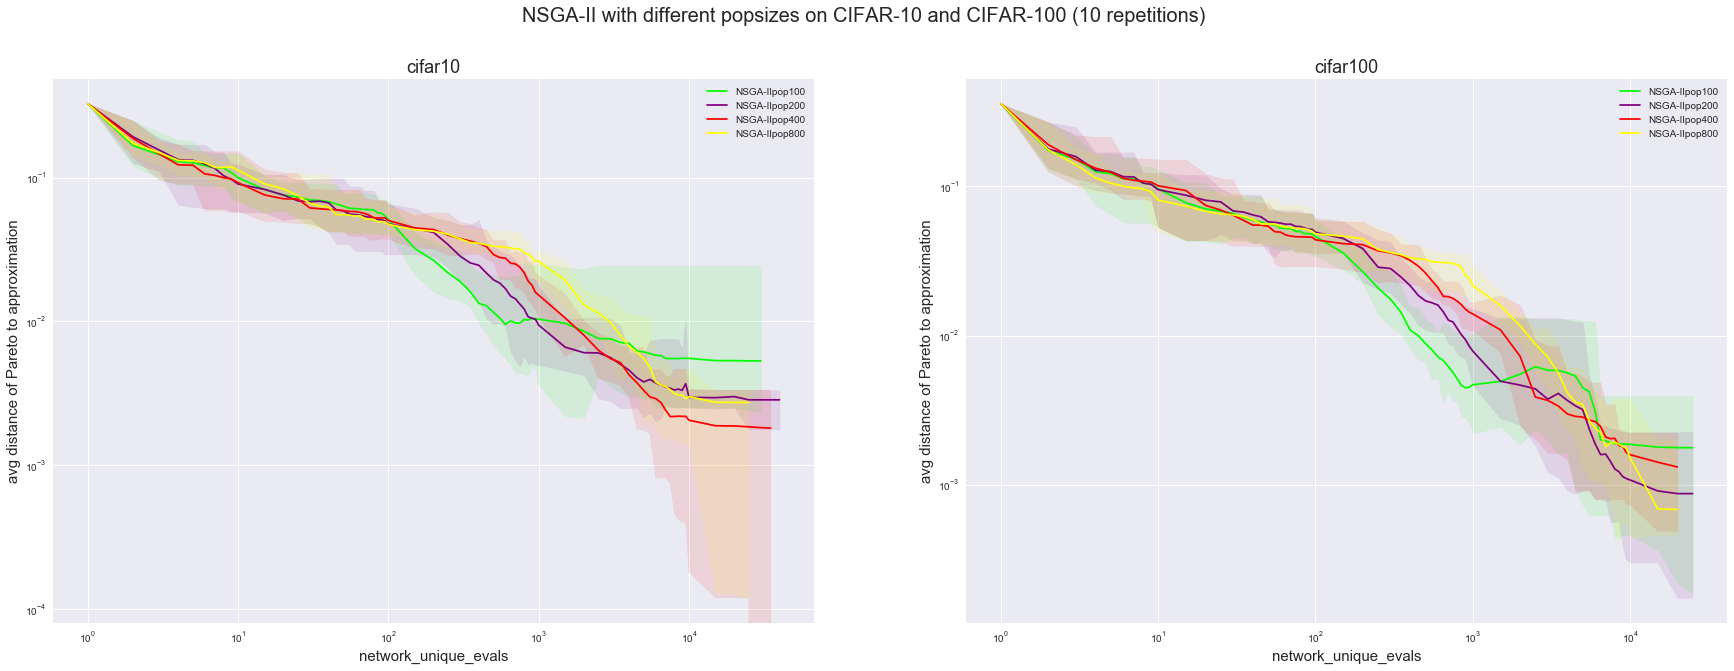

In [62]:
algos = ["NSGA-IIpop100", "NSGA-IIpop200", "NSGA-IIpop400", "NSGA-IIpop800"]#, "NSGA-II"]
colors = ["lime", "purple", "red", "yellow"] #, "green"]
benches = ["cifar10", "cifar100"]

for distType in ["avg"]: #"max"
    fig, ax = plt.subplots(1, 2, figsize=(30, 10))
    for i, bench in enumerate(benches):
        for algo, color in zip(algos, colors):
            ax[i].set_xscale("log")
            ax[i].set_yscale("log")
            if bench is "cifar10":
                ark = "ark8"
            else:
                ark = "ark7"
            plottyMO(ax[i], "../data/bench_"+bench+"_MO/" + algo + "_"+ark+"_"+bench+"/", algo, "network_unique_evals", distType=distType, minmax=True, color=color, forceGenerateSummaryFile=False)

            ax[i].set_title(bench)
            ax[i].set_xlabel(evalType)
            ax[i].set_ylabel(distType+" distance of Pareto to approximation")
#             ax[i].set_ylim(pow(10, -5), 1)
#             ax[i].set_xlim(1, pow(10, 7))
            ax[i].legend()
        fig.suptitle("NSGA-II with different popsizes on CIFAR-10 and CIFAR-100 (10 repetitions)")
        ax[i].grid()
#         ax[i].set_xscale("")

# MO plots (final results?)

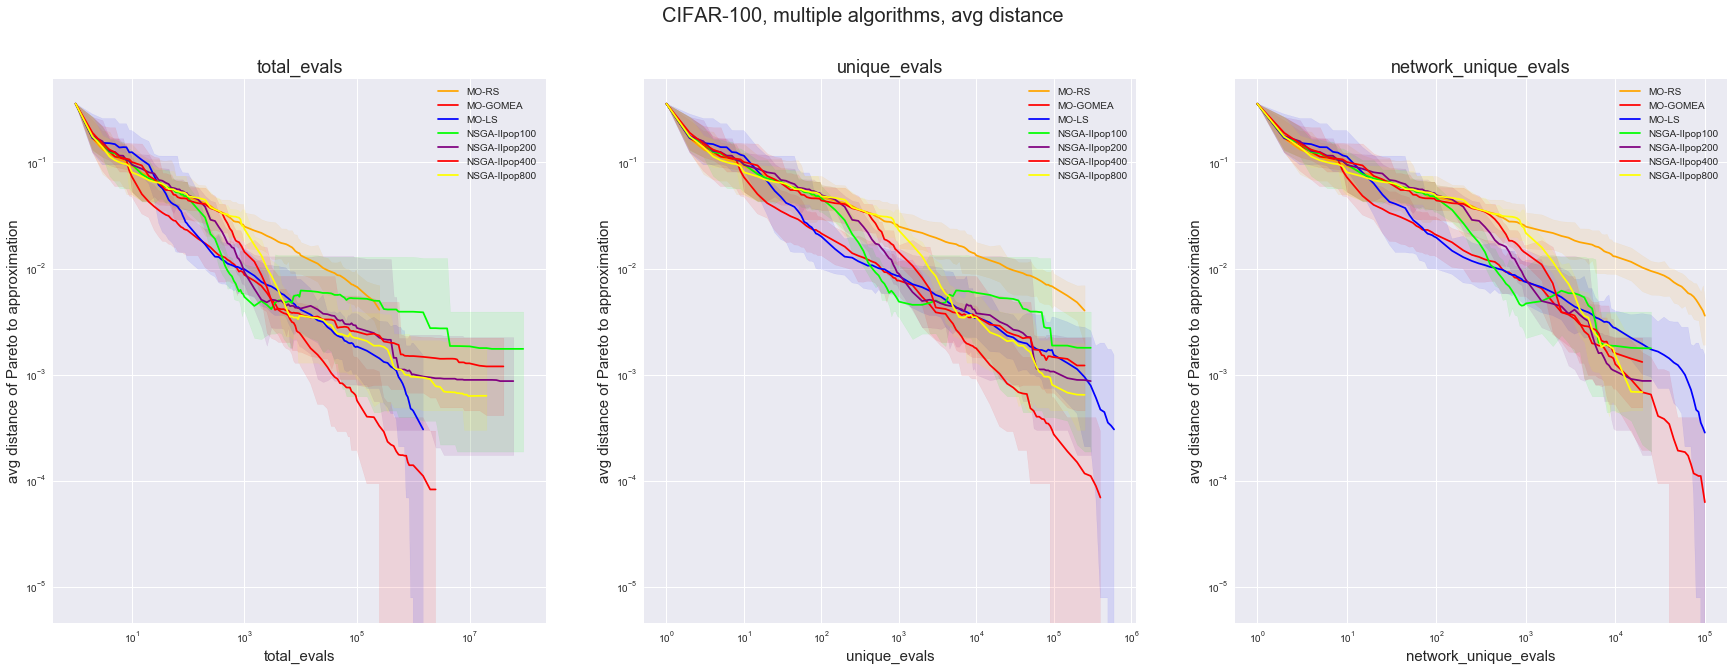

In [61]:
algos = ["MO-RS", "MO-GOMEA", "MO-LS", "NSGA-IIpop100", "NSGA-IIpop200", "NSGA-IIpop400", "NSGA-IIpop800"]#, "NSGA-II"]
colors = ["orange", "red", "blue", "lime", "purple", "red", "yellow"] #, "green"]
evalTypes = ["total_evals", "unique_evals", "network_unique_evals"]

for distType in ["avg"]: #"max"
    fig, ax = plt.subplots(1, 3, figsize=(30, 10))
    for i, evalType in enumerate(evalTypes):
        for algo, color in zip(algos, colors):
            ax[i].set_xscale("log")
            ax[i].set_yscale("log")
            plottyMO(ax[i], "../data/bench_cifar100_MO/" + algo + "_ark7_cifar100/", algo, evalType, distType=distType, minmax=True, color=color)

            ax[i].set_title(evalType)
            ax[i].set_xlabel(evalType)
            ax[i].set_ylabel(distType+" distance of Pareto to approximation")
#             ax[i].set_ylim(pow(10, -5), 1)
#             ax[i].set_xlim(1, pow(10, 7))
            ax[i].legend()
        fig.suptitle("CIFAR-100, multiple algorithms, " + distType + " distance")
        ax[i].grid()
#         ax[i].set_xscale("")

In [24]:
print(plt.style.available)
plt.style.use('seaborn-dark')

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


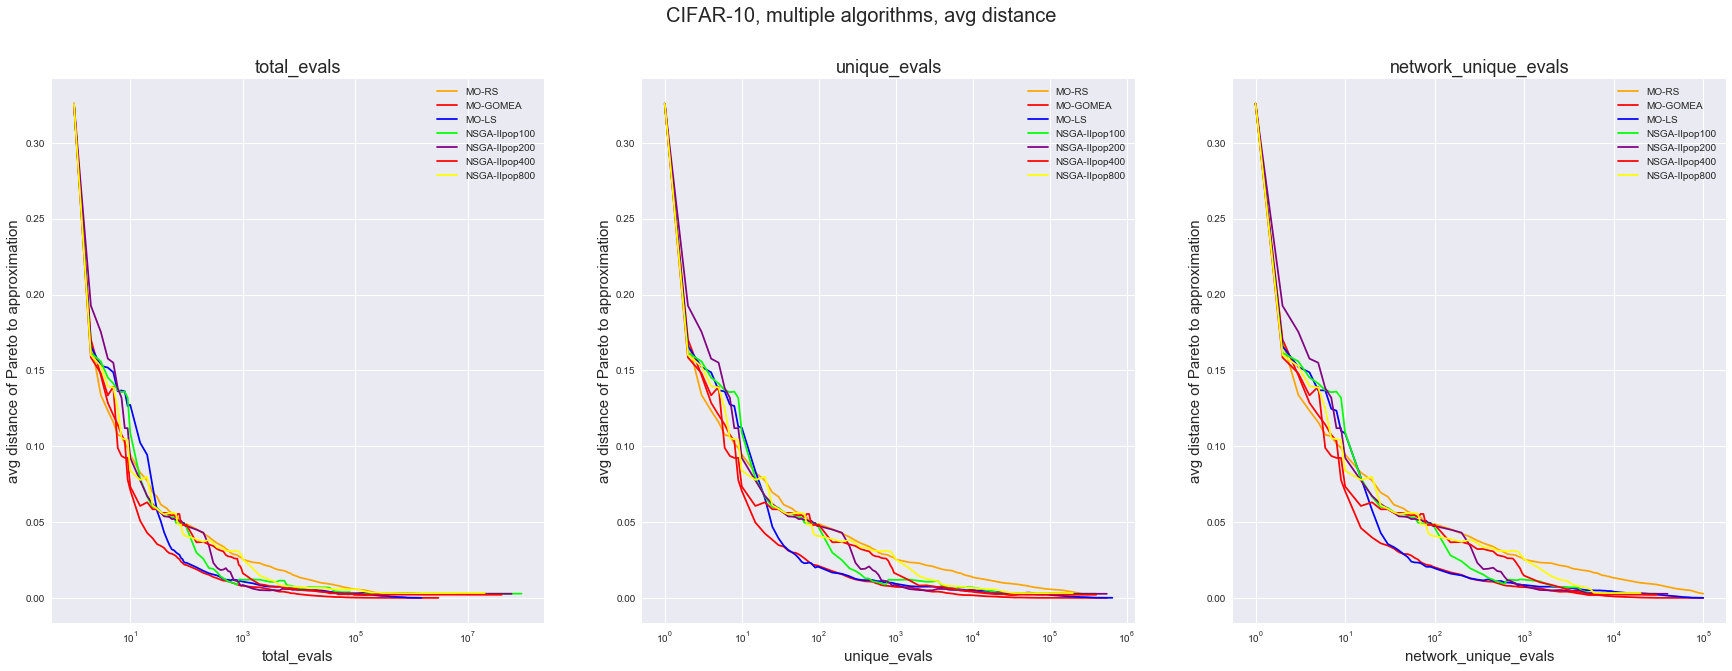

In [56]:
algos = ["MO-RS", "MO-GOMEA", "MO-LS", "NSGA-IIpop100", "NSGA-IIpop200", "NSGA-IIpop400", "NSGA-IIpop800"]#, "NSGA-II"]
colors = ["orange", "red", "blue", "lime", "purple", "red", "yellow"] #, "green"]

for distType in ["avg"]: #"max"
    fig, ax = plt.subplots(1, 3, figsize=(30, 10))
    for i, evalType in enumerate(["total_evals", "unique_evals", "network_unique_evals"]):
        for algo, color in zip(algos, colors):
            ax[i].set_xscale("log")
#             ax[i].set_yscale("log")
            plottyMO(ax[i], "../data/bench_cifar10_MO/" + algo + "_ark8_cifar10/", algo, evalType, distType=distType, minmax=False, color=color, alpha=0.05)

            ax[i].set_title(evalType)
            ax[i].set_xlabel(evalType)
            ax[i].set_ylabel(distType+" distance of Pareto to approximation")
#             ax[i].set_ylim(pow(10, -7), 1)
#             ax[i].set_xlim(1, pow(10, 7))
            ax[i].legend()
        fig.suptitle("CIFAR-10, multiple algorithms, " + distType + " distance")
        ax[i].grid()
    

# SO Plots

In [204]:
filteredAlgolist = glob.glob("../data/bench_cifar10_SO/GOM*")
print(filteredAlgolist)

['../data/bench_cifar10_SO/GOM_learned_ark8_cifar10', '../data/bench_cifar10_SO/GOM_uni_rand_ark8_cifar10', '../data/bench_cifar10_SO/GOM_ark6_rand_ark8_cifar10', '../data/bench_cifar10_SO/GOM_IncrLTR_uniOrd_ark8_cifar10', '../data/bench_cifar10_SO/GOM_uni_desc_ark8_cifar10', '../data/bench_cifar10_SO/GOM_ark6_desc_ark8_cifar10', '../data/bench_cifar10_SO/GOM_IncrLT_uni_ark8_cifar10', '../data/bench_cifar10_SO/GOM_IncrLTR_ark8_cifar10', '../data/bench_cifar10_SO/GOM_IncrLT_ark8_cifar10', '../data/bench_cifar10_SO/GOM_ark6_asc_ark8_cifar10', '../data/bench_cifar10_SO/GOM_uni_asc_ark8_cifar10', '../data/bench_cifar10_SO/GOM_IncrLTR_uni_ark8_cifar10']


In [329]:
lst = glob.glob("../data/bench_cifar10_SO/LS*")
print(lst)

['../data/bench_cifar10_SO/LS_ark8_cifar10', '../data/bench_cifar10_SO/LSS-0.05_ark8_cifar10', '../data/bench_cifar10_SO/LSS-0.01_ark8_cifar10']


In [206]:
lst = glob.glob("../data/bench_cifar10_SO/GOM*")
print(lst)

['../data/bench_cifar10_SO/GOM_learned_ark8_cifar10', '../data/bench_cifar10_SO/GOM_uni_rand_ark8_cifar10', '../data/bench_cifar10_SO/GOM_ark6_rand_ark8_cifar10', '../data/bench_cifar10_SO/GOM_IncrLTR_uniOrd_ark8_cifar10', '../data/bench_cifar10_SO/GOM_uni_desc_ark8_cifar10', '../data/bench_cifar10_SO/GOM_ark6_desc_ark8_cifar10', '../data/bench_cifar10_SO/GOM_IncrLT_uni_ark8_cifar10', '../data/bench_cifar10_SO/GOM_IncrLTR_ark8_cifar10', '../data/bench_cifar10_SO/GOM_IncrLT_ark8_cifar10', '../data/bench_cifar10_SO/GOM_ark6_asc_ark8_cifar10', '../data/bench_cifar10_SO/GOM_uni_asc_ark8_cifar10', '../data/bench_cifar10_SO/GOM_IncrLTR_uni_ark8_cifar10']


In [231]:
lst = glob.glob("../data/bench_cifar10_SO/SimpleGA*2p*")
print(lst)

['../data/bench_cifar10_SO/SimpleGAMut_pop100_2p_ark8_cifar10', '../data/bench_cifar10_SO/SimpleGAMut_pop400_2p_ark8_cifar10', '../data/bench_cifar10_SO/SimpleGAMut_pop1000_2p_ark8_cifar10', '../data/bench_cifar10_SO/SimpleGAMut_pop500_2p_ark8_cifar10', '../data/bench_cifar10_SO/SimpleGA_pop800_2p_ark8_cifar10', '../data/bench_cifar10_SO/SimpleGA_pop50_2p_ark8_cifar10', '../data/bench_cifar10_SO/SimpleGAMut_pop200_2p_ark8_cifar10', '../data/bench_cifar10_SO/SimpleGA_pop1000_2p_ark8_cifar10', '../data/bench_cifar10_SO/SimpleGA_pop500_2p_ark8_cifar10', '../data/bench_cifar10_SO/SimpleGA_pop100_2p_ark8_cifar10', '../data/bench_cifar10_SO/SimpleGA_pop400_2p_ark8_cifar10', '../data/bench_cifar10_SO/SimpleGAMut_pop50_2p_ark8_cifar10', '../data/bench_cifar10_SO/SimpleGA_pop200_2p_ark8_cifar10', '../data/bench_cifar10_SO/SimpleGAMut_pop800_2p_ark8_cifar10']


In [208]:
lst = glob.glob("../data/bench_cifar10_SO/RS*")

In [237]:
lst = ["../data/bench_cifar10_SO/RS_ark8_cifar10", 
       "../data/bench_cifar10_SO/LS_ark8_cifar10", 
       "../data/bench_cifar10_SO/GOM_learned_ark8_cifar10", 
       "../data/bench_cifar10_SO/SimpleGAMut_pop100_uni_ark8_cifar10"]

Generating summary file
../data/bench_cifar10_SO/LSS-0.05_ark8_cifar10/experiment.json
reps 30
create file ../data/bench_cifar10_SO/LSS-0.05_ark8_cifar10/SO_info_average.json
Generating summary file
../data/bench_cifar10_SO/LSS-0.01_ark8_cifar10/experiment.json
reps 30
create file ../data/bench_cifar10_SO/LSS-0.01_ark8_cifar10/SO_info_average.json


Text(0, 0.5, 'Validation accuracy')

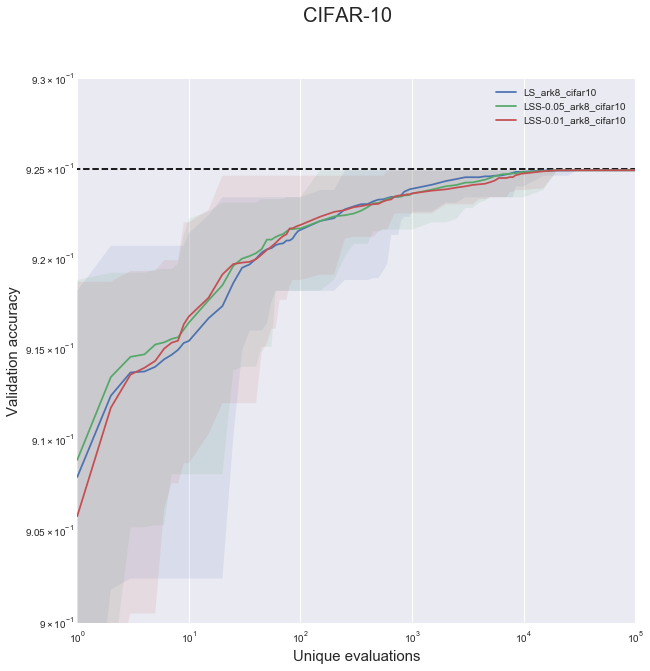

In [330]:
fig, axi = plt.subplots(1, 1, figsize=(10, 10))
ax = [axi]
i = 0
# algolist = os.listdir("../data/bench_cifar100_SO/")
# print(algolist)
evalType = "network_unique_evals"
# for i, popsize in enumerate(["50", "100", "200", "400", "800"]):
for algoRaw in lst:
    algo = algoRaw.replace("../data/bench_cifar10_SO/", '')
#     print(algo)
    color = ""

    if '_ark8_cifar10' not in algo:
        continue

#     if popsize + "_" not in algo:
#         continue

#         if 'ark6' in algo or '3p' in algo:
#             continue

#         if 'pop200_' not in algo and 'pop100_' not in algo and 'pop500_' not in algo and 'pop1000_' not in algo:
#             continue

#         if 'uni' in algo:
#             color = "red"
#         elif '1p' in algo:
#             color = "green"
#         elif '2p' in algo:
#             color = "orange"
#         else:
#             color = "blue"

#         if 'IncrLT' in algo:
#             continue

#         if "learned" in algo:
#             color = "white"
#         elif 'ark6' in algo:
#             color = "cyan"
#         if 'Mut' in algo:
#             color="red"
#         else:
#             color="blue"

    plottySO(ax[i], "../data/bench_cifar10_SO/" + algo + "/", algo, evalType, minmax=True, forceGenerateSummaryFile=False, color=color)

plt.hlines(0.925, 0, 100000, linestyles='dashed')
ax[i].set_ylim(0.9, 0.93)
#     ax[i].set_ylim(0.68, 0.71)
ax[i].set_xlim(1, 100000)
ax[i].legend()
fig.suptitle("CIFAR-10")
ax[i].grid()
ax[i].set_yscale("log")
ax[i].set_xscale("log")
# ax[i].set_title("popsize=" + str(popsize))
ax[i].set_xlabel("Unique evaluations")
ax[i].set_ylabel("Validation accuracy")
#     ax[i].set_ylabel(distType+" distance of Pareto to approximation")


# PLOTS

## Init

In [861]:
def initPlottingStuff(axlabelsize=20, ticklabelsize=18, legendfontsize=20):
    from matplotlib.ticker import FormatStrFormatter
    mpl.rcParams.update(mpl.rcParamsDefault)
    import seaborn as sns
    sns.set()

    sns.set_palette("bright")
#     colors = [sns.color_palette()[2],
#     #         "red",
#              sns.color_palette()[3],
#              sns.color_palette()[1],
#              sns.color_palette()[9]]
    color_bg_default = "#EAEAF2"
    color_bg_inset = (245/256, 245/256, 250/256)
    color_zoom_border = "#50668a"
    global colors
    colors = ["green", "red", sns.color_palette()[1], "blue"]

    mpl.rcParams['axes.titlesize'] = axlabelsize
    mpl.rcParams['axes.labelsize'] = axlabelsize
    mpl.rcParams['ytick.labelsize'] = ticklabelsize
    mpl.rcParams['xtick.labelsize'] = ticklabelsize
    mpl.rcParams['legend.fontsize'] = legendfontsize
initPlottingStuff()

## C10 SO

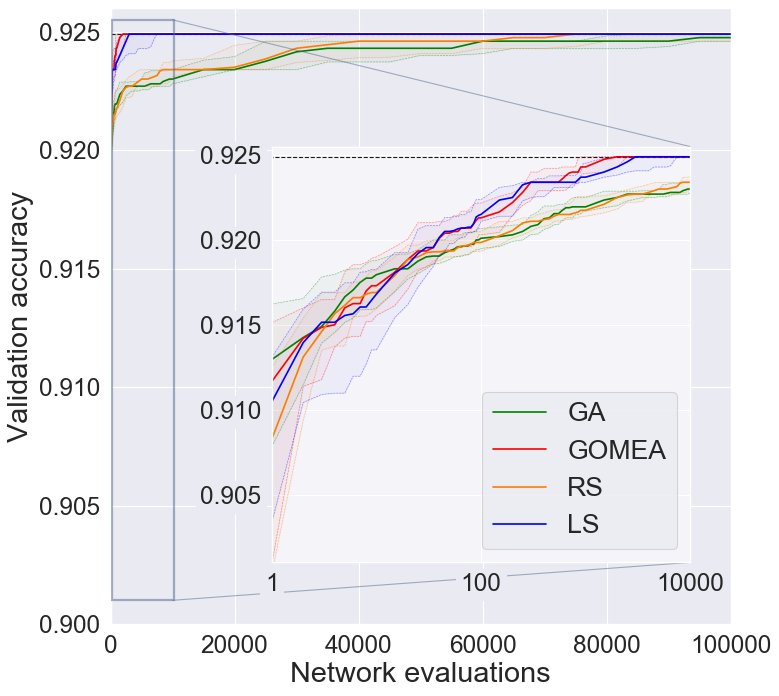

In [997]:
initPlottingStuff(26, 22, 24)
lst = ["../data/bench_cifar10_SO/SimpleGAMut_pop100_2p_ark8_cifar10",
       "../data/bench_cifar10_SO/GOM_learned_ark8_cifar10",
       "../data/bench_cifar10_SO/RS_ark8_cifar10", 
       "../data/bench_cifar10_SO/LS_ark8_cifar10"]

fig, ax1 = plt.subplots(1, 1, figsize=(10, 10), dpi=80)
ax2 = ax1.inset_axes([0.26, 0.1, 0.675, 0.675])
i = 0
evalType = "network_unique_evals"
for j, algoRaw in enumerate(lst):
    algo = algoRaw.replace("../data/bench_cifar10_SO/", '')
    
    algoLabel = algo.replace('_learned','') \
        .replace('Mut_pop100_2p','') \
        .replace('_ark8_cifar10','') \
        .replace('GOM', 'GOMEA') \
        .replace('SimpleGA', 'GA')

    plot="validation"
    plottySO(ax1, "../data/bench_cifar10_SO/" + algo + "/", algoLabel, evalType, plot=plot, median=True, percentile=25, std=True, minmax=False, forceGenerateSummaryFile=False, color=colors[j], alpha=0.03)
    plottySO(ax2, "../data/bench_cifar10_SO/" + algo + "/", algoLabel, evalType, plot=plot, median=True, percentile=25, std=True, minmax=False, forceGenerateSummaryFile=False, color=colors[j], alpha=0.03)

opt = 0.9248999357223511
ax1.hlines(opt, 0, 100000, linestyle='dashed', lw=1)
ax1.set_ylim(0.9, 0.926)
# ax1.set_title("CIFAR-10")
ax1.set_xlabel("Network evaluations")
ax1.set_ylabel("Validation accuracy")# on CIFAR-10")
ax1.set_xlim(0, 100000)

ax2.hlines(opt, 0, 100000, linestyle='dashed', lw=1)
ax2.set_xlim(1, 10000)
ax2.set_xscale("log")
ax2.set_ylim(0.901, 0.9255)
ax2.set_facecolor(color_bg_inset)
ax2.legend(loc=4)
ax2.set_xticklabels(ax2.get_xticks(), backgroundcolor=color_bg_default)
ax2.set_yticklabels(ax2.get_yticks(), backgroundcolor=color_bg_default)
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax2.xaxis.set_major_formatter(FormatStrFormatter('%d'))

rect, connector_lines = ax1.indicate_inset_zoom(ax2, lw=2, edgecolor=color_zoom_border, alpha=0.5)
rect.set_xy((200, 0.901))

# plt.savefig('imgs/C10_SO.png', dpi = 300, bbox_inches='tight')
# plt.savefig('imgs/C10_SO.pdf', dpi = 300, bbox_inches='tight', format='pdf')

##### Test accuracy

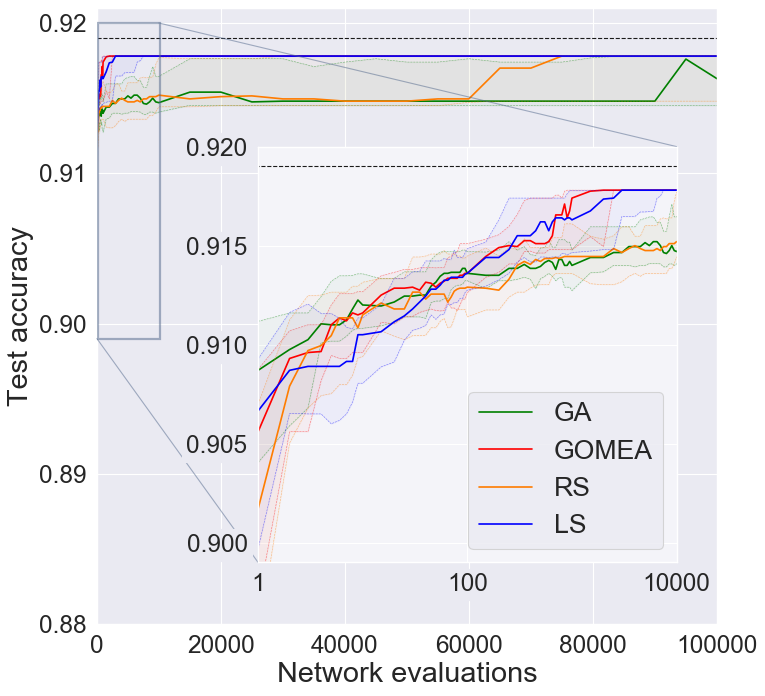

In [1007]:
initPlottingStuff(26, 22, 24)
lst = ["../data/bench_cifar10_SO/SimpleGAMut_pop100_2p_ark8_cifar10",
       "../data/bench_cifar10_SO/GOM_learned_ark8_cifar10",
       "../data/bench_cifar10_SO/RS_ark8_cifar10", 
       "../data/bench_cifar10_SO/LS_ark8_cifar10"]

fig, ax1 = plt.subplots(1, 1, figsize=(10, 10), dpi=80)
ax2 = ax1.inset_axes([0.26, 0.1, 0.675, 0.675])
i = 0
evalType = "network_unique_evals"
for j, algoRaw in enumerate(lst):
    algo = algoRaw.replace("../data/bench_cifar10_SO/", '')
    
    algoLabel = algo.replace('_learned','') \
        .replace('Mut_pop100_2p','') \
        .replace('_ark8_cifar10','') \
        .replace('GOM', 'GOMEA') \
        .replace('SimpleGA', 'GA')

    plot="test"
    plottySO(ax1, "../data/bench_cifar10_SO/" + algo + "/", algoLabel, evalType, plot=plot, median=True, percentile=25, std=True, minmax=False, forceGenerateSummaryFile=False, color=colors[j], alpha=0.03)
    plottySO(ax2, "../data/bench_cifar10_SO/" + algo + "/", algoLabel, evalType, plot=plot, median=True, percentile=25, std=True, minmax=False, forceGenerateSummaryFile=False, color=colors[j], alpha=0.03)

opt = 0.919
ax1.hlines(opt, 0, 100000, linestyle='dashed', lw=1)
ax1.set_ylim(0.88, 0.921)
# ax1.set_title("CIFAR-10")
ax1.set_xlabel("Network evaluations")
ax1.set_ylabel("Test accuracy")# on CIFAR-10")
ax1.set_xlim(0, 100000)
ax1.yaxis.set_major_locator(plt.MultipleLocator(0.01))

ax2.hlines(opt, 0, 100000, linestyle='dashed', lw=1)
ax2.set_xlim(1, 10000)
ax2.set_xscale("log")
ax2.set_ylim(0.899, 0.92)
ax2.set_facecolor(color_bg_inset)
ax2.legend(loc=4)
ax2.set_xticklabels(ax2.get_xticks(), backgroundcolor=color_bg_default)
ax2.set_yticklabels(ax2.get_yticks(), backgroundcolor=color_bg_default)
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax2.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax2.yaxis.set_major_locator(plt.MultipleLocator(0.005))

rect, connector_lines = ax1.indicate_inset_zoom(ax2, lw=2, edgecolor=color_zoom_border, alpha=0.5)
rect.set_x(200)

plt.savefig('imgs/C10_SO_test.png', dpi = 300, bbox_inches='tight')
plt.savefig('imgs/C10_SO_test.pdf', dpi = 300, bbox_inches='tight', format='pdf')

## C100 SO

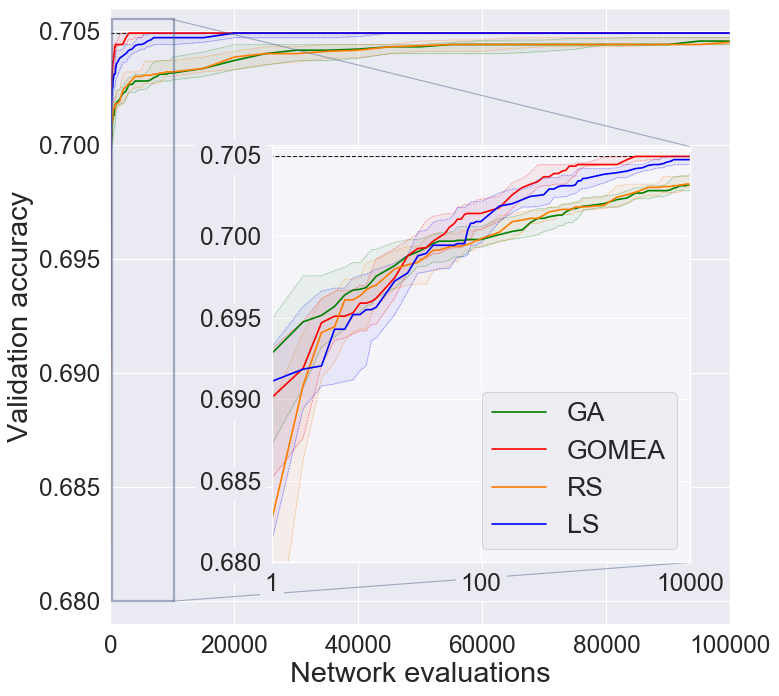

In [1003]:
initPlottingStuff(26, 22, 24)
lst = ["../data/bench_cifar100_SO/SimpleGAMut_pop100_2p_ark7_cifar100",
       "../data/bench_cifar100_SO/GOM_learned_ark7_cifar100",
       "../data/bench_cifar100_SO/RS_ark7_cifar100", 
       "../data/bench_cifar100_SO/LS_ark7_cifar100"]

fig, ax1 = plt.subplots(1, 1, figsize=(10, 10), dpi=80)
ax2 = ax1.inset_axes([0.26, 0.1, 0.675, 0.675])
i = 0
evalType = "network_unique_evals"
for j, algoRaw in enumerate(lst):
    algo = algoRaw.replace("../data/bench_cifar100_SO/", '')
    
    algoLabel = algo.replace('_learned','') \
        .replace('Mut_pop100_2p','') \
        .replace('_ark7_cifar100','') \
        .replace('GOM', 'GOMEA') \
        .replace('SimpleGA', 'GA')

    plot = "validation"
    plottySO(ax1, "../data/bench_cifar100_SO/" + algo + "/", algoLabel, evalType, plot=plot, median=True, percentile=25, std=True, minmax=False, forceGenerateSummaryFile=False, color=colors[j], alpha=0.05)
    plottySO(ax2, "../data/bench_cifar100_SO/" + algo + "/", algoLabel, evalType, plot=plot, median=True, percentile=25, std=True, minmax=False, forceGenerateSummaryFile=False, color=colors[j], alpha=0.05)

opt = 0.7048999667167664
ax1.hlines(opt, 0, 100000, linestyle='dashed', lw=1)
ax1.set_ylim(0.679, 0.706)
# ax1.set_title("CIFAR-100")
ax1.set_xlabel("Network evaluations")
ax1.set_ylabel("Validation accuracy")# on CIFAR-100")
log = False
if log:
    ax1.set_xscale("log")
else:
    ax1.set_xlim(0, 100000)

ax2.hlines(opt, 0, 100000, linestyle='dashed', lw=1)
ax2.set_xlim(1, 10000)
ax2.set_xscale("log")
ax2.set_ylim(0.68, 0.7055)
ax2.set_facecolor(color_bg_inset)
ax2.legend(loc=4)
ax2.set_xticklabels(ax2.get_xticks(), backgroundcolor=color_bg_default)
ax2.set_yticklabels(ax2.get_yticks(), backgroundcolor=color_bg_default)
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax2.xaxis.set_major_formatter(FormatStrFormatter('%d'))

rect, connector_lines = ax1.indicate_inset_zoom(ax2, lw=2, edgecolor=color_zoom_border, alpha=0.5)
rect.set_xy((200, 0.68))

plt.savefig('imgs/C100_SO.png', dpi = 300, bbox_inches='tight')
plt.savefig('imgs/C100_SO.pdf', dpi = 300, bbox_inches='tight', format='pdf')

##### Test accuracy

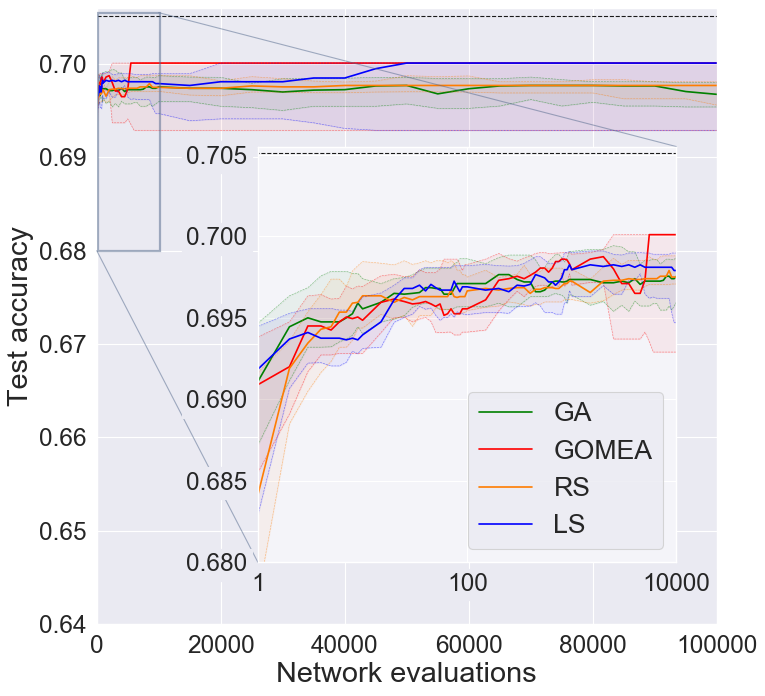

In [1005]:
initPlottingStuff(26, 22, 24)
lst = ["../data/bench_cifar100_SO/SimpleGAMut_pop100_2p_ark7_cifar100",
       "../data/bench_cifar100_SO/GOM_learned_ark7_cifar100",
       "../data/bench_cifar100_SO/RS_ark7_cifar100", 
       "../data/bench_cifar100_SO/LS_ark7_cifar100"]

fig, ax1 = plt.subplots(1, 1, figsize=(10, 10), dpi=80)
ax2 = ax1.inset_axes([0.26, 0.1, 0.675, 0.675])
i = 0
evalType = "network_unique_evals"
for j, algoRaw in enumerate(lst):
    algo = algoRaw.replace("../data/bench_cifar100_SO/", '')
    
    algoLabel = algo.replace('_learned','') \
        .replace('Mut_pop100_2p','') \
        .replace('_ark7_cifar100','') \
        .replace('GOM', 'GOMEA') \
        .replace('SimpleGA', 'GA')

    plot = "test"
    plottySO(ax1, "../data/bench_cifar100_SO/" + algo + "/", algoLabel, evalType, plot=plot, median=True, percentile=25, std=True, minmax=False, forceGenerateSummaryFile=False, color=colors[j], alpha=0.05)
    plottySO(ax2, "../data/bench_cifar100_SO/" + algo + "/", algoLabel, evalType, plot=plot, median=True, percentile=25, std=True, minmax=False, forceGenerateSummaryFile=False, color=colors[j], alpha=0.05)

opt = 0.7051
ax1.hlines(opt, 0, 100000, linestyle='dashed', lw=1)
ax1.set_ylim(0.64, 0.706)
# ax1.set_title("CIFAR-100")
ax1.set_xlabel("Network evaluations")
ax1.set_ylabel("Test accuracy")# on CIFAR-100")
log = False
if log:
    ax1.set_xscale("log")
else:
    ax1.set_xlim(0, 100000)

ax2.hlines(opt, 0, 100000, linestyle='dashed', lw=1)
ax2.set_xlim(1, 10000)
ax2.set_xscale("log")
ax2.set_ylim(0.68, 0.7055)
ax2.set_facecolor(color_bg_inset)
ax2.legend(loc=4)
ax2.set_xticklabels(ax2.get_xticks(), backgroundcolor=color_bg_default)
ax2.set_yticklabels(ax2.get_yticks(), backgroundcolor=color_bg_default)
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax2.xaxis.set_major_formatter(FormatStrFormatter('%d'))

rect, connector_lines = ax1.indicate_inset_zoom(ax2, lw=2, edgecolor=color_zoom_border, alpha=0.5)
rect.set_xy((200, 0.68))

plt.savefig('imgs/C100_SO_test.png', dpi = 300, bbox_inches='tight')
plt.savefig('imgs/C100_SO_test.pdf', dpi = 300, bbox_inches='tight', format='pdf')

## F: Plot #Pareto points

In [134]:
def plotParetoPoints(axis, folder, label, evaltype="network_unique_evals", median=False, percentile=10, minmax=False, std=False, color="red", alpha=0.1):
    fn = folder + "MO_info_average.json"
    if not FileCheck(fn):
        print("No summary file")
        return
                
    with open(fn) as json_file:
        data = json.load(json_file)
        data = data[evalType]
        identifier = "pareto_points_found"
        X = data["evals"]
        
        if median:
            Y = data[identifier+"_med"]
        else:
            Y = data[identifier]
            
        axis.plot(X, Y, label=label, color=color)

        if median:
            Ymin = data[identifier+"_p" + str(percentile)]
            Ymax = data[identifier+"_p" + str(100 - percentile)]
        elif minmax:
            Ymin = data[identifier+"_min"]
            Ymax = data[identifier+"_max"]
        elif std:
            Ymin = np.array(Y) - np.array(data[identifier+"_std"])
            Ymax = np.array(Y) + np.array(data[identifier+"_std"])

        if median or minmax or std:
            axis.fill_between(X, Ymin, Ymax, color=color, alpha=alpha)
            axis.plot(X, Ymin, color=color, ls="dashed", lw=0.5, alpha=0.5)
            axis.plot(X, Ymax, color=color, ls="dashed", lw=0.5, alpha=0.5)
    

## C10 MO

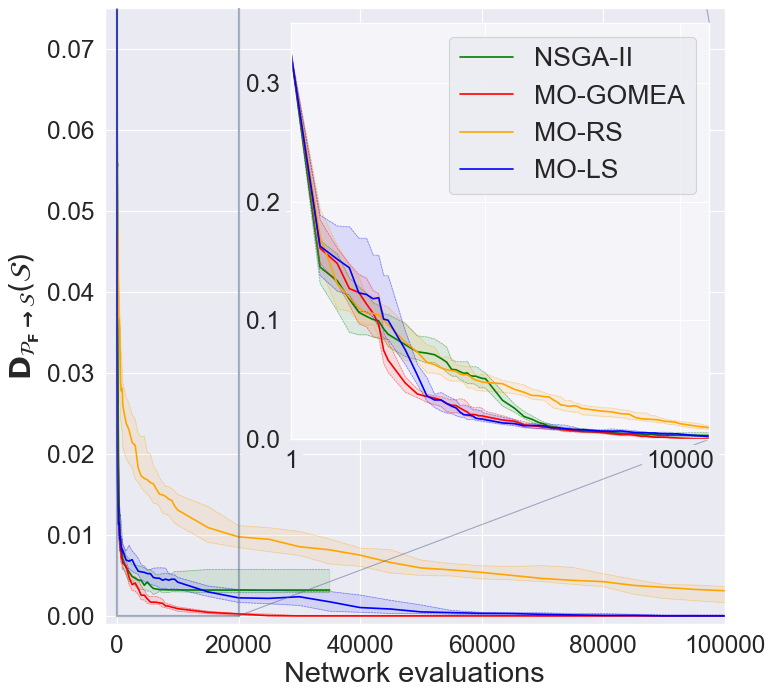

In [838]:
initPlottingStuff(26, 22, 24)
lst = ["../data/bench_cifar10_MO/NSGA-II_ark8_cifar10",
       "../data/bench_cifar10_MO/MO-GOMEA_ark8_cifar10",
       "../data/bench_cifar10_MO/MO-RS_ark8_cifar10", 
       "../data/bench_cifar10_MO/MO-LS_ark8_cifar10"]

fig, ax1 = plt.subplots(1, 1, figsize=(10, 10), dpi=80)
ax2 = ax1.inset_axes([0.3, 0.3, 0.675, 0.675])
# fig2, ax3 = plt.subplots(1, 1, figsize=(10, 10), dpi=80)

evalType = "network_unique_evals"
for j, algoRaw in enumerate(lst):
    algo = algoRaw.replace("../data/bench_cifar10_MO/", '')
    
    algoLabel = algo.replace('pop10','') \
        .replace('_ark8_cifar10','') \
        .replace('_final', '')
    
    for ax in [ax1, ax2]:
        plottyMO(ax, "../data/bench_cifar10_MO/" + algo + "/", algoLabel, \
                 evalType, median=True, percentile=25, std=False, minmax=False, \
                 forceGenerateSummaryFile=False, color=colors[j])
#     plotParetoPoints(ax3, "../data/bench_cifar10_MO/" + algo + "/", algoLabel, \
#                      evalType, median=True, percentile=25, std=False, minmax=True, \
#                      color=colors[j])

ax1.set_xlim(-2000, 100000)
ax1.set_ylim(-0.001, 0.075)
# ax1.set_title("CIFAR-10")
ax1.set_xlabel("Network evaluations")
ax1.set_ylabel(r'$\mathbf{D_{\mathcal{P}_{F} \rightarrow \mathcal{S}}}(\mathbf{\mathcal{S}})$')
# ax1.set_ylabel("Average distance from approximation set to Pareto front")

log = False
if log:
    ax1.set_xscale("log")
    ax3.set_xscale("log")

ax2.set_xlim(1, 20000)
ax2.set_ylim(0, 0.35)
ax2.set_xscale("log")
ax2.set_facecolor(color_bg_inset)
ax2.legend(loc=1)
ax2.set_xticklabels(ax2.get_xticks(), backgroundcolor=color_bg_default)
ax2.set_yticklabels(ax2.get_yticks(), backgroundcolor=color_bg_default)
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax2.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax2.yaxis.set_major_locator(plt.MultipleLocator(0.1))

rect, connector_lines = ax1.indicate_inset_zoom(ax2, lw=2, edgecolor=color_zoom_border, alpha=0.5)
rect.set_height(0.08)
connector_lines[3].set_visible(False)
rect.set_xy((1, 0))
# print(rect)
# ax1.plot([20000, 95000], [0.35, 0.0712], lw=1, color=color_zoom_border, alpha=0.5)
ax1.plot([20000, 97500], [0.4, 0.073], lw=1, color=color_zoom_border, alpha=0.5)


fig.savefig('imgs/C10_MO.png', dpi = 300, bbox_inches='tight')
fig.savefig('imgs/C10_MO.pdf', dpi = 300, bbox_inches='tight', format='pdf')

# opt = 47
# ax3.hlines(opt, 0, 100000, linestyle='dashed', lw=1)
# ax3.set_xlabel("Unique evaluations")
# ax3.set_ylabel("Pareto points found")
# ax3.grid()
# ax3.set_title("CIFAR-10")

## C100 MO

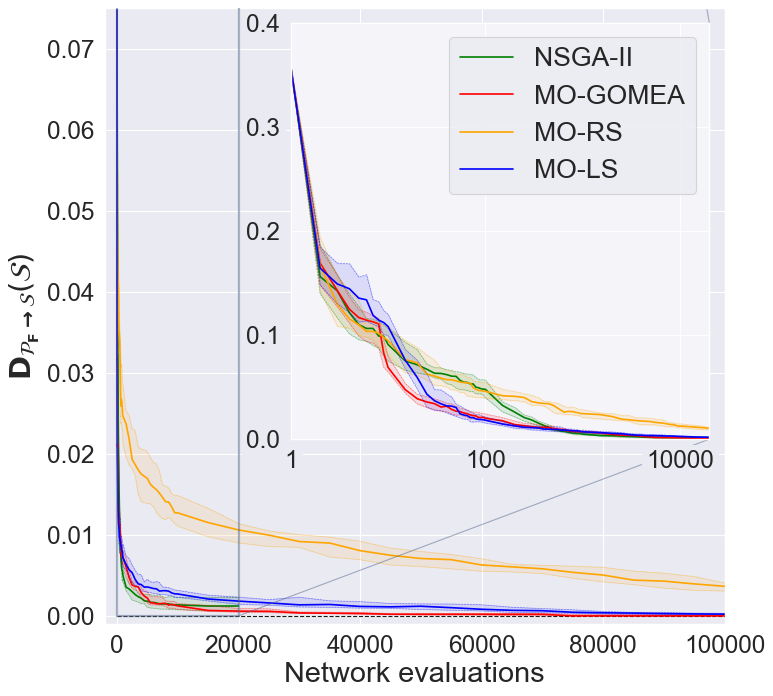

In [839]:
initPlottingStuff(26, 22, 24)
lst = ["../data/bench_cifar100_MO/NSGA-II_ark7_cifar100",
       "../data/bench_cifar100_MO/MO-GOMEA_ark7_cifar100",
       "../data/bench_cifar100_MO/MO-RS_ark7_cifar100", 
       "../data/bench_cifar100_MO/MO-LS_ark7_cifar100"]

fig, ax1 = plt.subplots(1, 1, figsize=(10, 10), dpi=80)
ax2 = ax1.inset_axes([0.3, 0.3, 0.675, 0.675])
# fig2, ax3 = plt.subplots(1, 1, figsize=(10, 10), dpi=80)

evalType = "network_unique_evals"
for j, algoRaw in enumerate(lst):
    algo = algoRaw.replace("../data/bench_cifar100_MO/", '')
    
    algoLabel = algo.replace('pop10','') \
        .replace('_ark7_cifar100','') \
        .replace('_final', '')
    
    for ax in [ax1, ax2]:
        plottyMO(ax, "../data/bench_cifar100_MO/" + algo + "/", algoLabel, \
                 evalType, median=True, percentile=25, std=False, minmax=False, \
                 forceGenerateSummaryFile=False, color=colors[j])
#     plotParetoPoints(ax3, "../data/bench_cifar100_MO/" + algo + "/", algoLabel, \
#                      evalType, median=True, percentile=25, std=False, minmax=True, \
#                      color=colors[j])

ax1.hlines(0, 0, 100000, linestyle='dashed', lw=1)
ax1.set_xlim(-2000, 100000)
ax1.set_ylim(-0.001, 0.075)
# ax1.set_title("CIFAR-100")
ax1.set_xlabel("Network evaluations")
ax1.set_ylabel(r'$\mathbf{D_{\mathcal{P}_{F} \rightarrow \mathcal{S}}}(\mathbf{\mathcal{S}})$')
# ax1.set_ylabel("Average distance from approximation set to Pareto front")

log = False
if log:
    ax1.set_xscale("log")
    ax3.set_xscale("log")

ax2.set_xlim(1, 20000)
ax2.set_ylim(0, 0.4)
ax2.set_xscale("log")
ax2.set_facecolor(color_bg_inset)
ax2.legend(loc=1)
ax2.set_xticklabels(ax2.get_xticks(), backgroundcolor=color_bg_default)
ax2.set_yticklabels(ax2.get_yticks(), backgroundcolor=color_bg_default)
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax2.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax2.yaxis.set_major_locator(plt.MultipleLocator(0.1))

rect, connector_lines = ax1.indicate_inset_zoom(ax2, lw=2, edgecolor=color_zoom_border, alpha=0.5)
rect.set_height(0.08)
connector_lines[3].set_visible(False)
rect.set_xy((1, 0))
# print(rect)
ax1.plot([20000, 97500], [0.4, 0.073], lw=1, color=color_zoom_border, alpha=0.5)

fig.savefig('imgs/C100_MO.png', dpi = 300, bbox_inches='tight')
fig.savefig('imgs/C100_MO.pdf', dpi = 300, bbox_inches='tight', format='pdf')

# opt = 51
# ax3.hlines(opt, 0, 100000, linestyle='dashed', lw=1)
# ax3.set_xlabel("Unique evaluations")
# ax3.set_ylabel("Pareto points found")
# ax3.grid()
# ax3.set_title("CIFAR-100")

## F: PlotArchive (from OnlineFunctions.ipynb)

In [1151]:
def plotArchive(ax, filename, pointInTime, cifar="c10", plot="validation", color="black", label="undefined", marker="o"):
#     folder = "data/online/"
#     queriedFilename = folder + algorithm + "_run" + str(run) + "_seed*" + "/progress0.json"
#     filenames = glob.glob(queriedFilename)
#     filename = filenames[0]
    
    with open (filename) as json_file:
        data = json.load(json_file)
        data = data['changes_on_interval']['network_unique_evals']
                
        # This is to find the index in the json at which the unique evaluations is equal to "pointInTime"
        for indexOfData in range(100000):
            if indexOfData >= len(data["evals"]):
                print("There are no", pointInTime ,"network unique evaluations yet (data until", data["network_unique_evals"][indexOfData-1],")")
                return
            networkUniqueEvals = data["evals"][indexOfData]
            if networkUniqueEvals == pointInTime:
                break
                
        archive = data["elitist_archive_fitness"][indexOfData]
        
        np_archive = np.zeros((len(archive), 2))
        np_archive_test = np.zeros((len(archive), 2))
        np_archive_genotypes = [""] * len(archive)
        for i, item in enumerate(archive):
            np_archive[i,0] = item['f'][0]
            np_archive[i,1] = item['f'][1]
            np_archive_test[i,1] = item['f'][1]
            np_archive_genotypes[i] = item['g']
            
        # Retrieve test accuracies for genotypes
        bench = benchmark_data_c10_raw if cifar is "c10" else benchmark_data_c100_raw
        np_archive_test[:,0] = getTestAcc(np_archive_genotypes, bench)
        
        # Sort the arrays
        sortingIndices = np.argsort(np_archive[:,1])
        np_archive = np_archive[sortingIndices]
        np_archive_test = np_archive_test[sortingIndices]
        
        np_archive_test, np_archive_test_dominated = filterDominatedSolutions(np_archive_test)
        
        if plot is "validation":
            Y_blockyfront = generateBlockyFront(np_archive)
            Y_archive = np_archive
        elif plot is "test":
            Y_blockyfront = generateBlockyFront(np_archive_test)
            Y_archive = np_archive_test
#             ax.scatter(np_archive_test_dominated[:,0], np_archive_test_dominated[:,1], color=color, alpha=0.5, marker=marker, zorder=10, s=25)
        
        ax.scatter(Y_archive[:,0], Y_archive[:,1], label=label, color=color, marker=marker, zorder=10, s=25)
#         ax.plot(Y_blockyfront[:,0], Y_blockyfront[:,1], color=color, zorder=5, lw=0.5)
        ax.plot(Y_blockyfront[:,0], Y_blockyfront[:,1], color=color, zorder=5, lw=1, ls=(0, (5, 1)))

# Generates a np-array that contains the archive's values and their intersection points. This array can be used for plotting the line of the front.
def generateBlockyFront(np_archive):
    np_archive = np_archive[np.argsort(np_archive[:, 1][::-1])]
    np_blocky_archive = np.zeros((len(np_archive[:,1]) * 2 + 1, 2))
    
    np_blocky_archive[0,1] = np_archive[0,1]
    i = 0
    for i in range(len(np_archive[:,0])):
        np_blocky_archive[i*2 + 1, :] = np_archive[i,:]
        np_blocky_archive[i*2 + 2, 0] = np_archive[i,0]
        if i != (len(np_archive[:,0]) - 1):
            np_blocky_archive[i*2 + 2, 1] = np_archive[i+1,1]
    
    return np_blocky_archive

## F: plotSearchSpace

In [634]:
def plotSearchSpace(ax, dataset, amount=1000):
    fn = "../benchmarks/"+dataset+"/unique_fitness_values_normalized.json"
    with open (fn) as json_file:
        data = json.load(json_file)
        np_data = np.array(data)
#         print(np_data.shape)
        if amount > 50000:
            print("cap of 50000 is reached. Otherwise will become unresponding")
        amount = min(min(amount, len(data)), 50000)
        ax.scatter(np_data[:amount,0], np_data[:amount,1], color="grey", alpha=0.1, s=0.7)

In [256]:
plotPoints(ax, "ark8")

## F: plotPareto

In [1144]:
def plotTruePareto(ax, dataset, plot="validation"):
    suffix = "_testacc" if plot is "test" else ""
    fn = "../benchmarks/"+dataset+"/pareto"+suffix+".json"
    with open(fn) as json_file:
        data = json.load(json_file)
        trueFront = np.array(data['14']['fitness'])

        color=color_zoom_border
        ax.scatter(trueFront[:,0], trueFront[:,1], s=1, color=color)
        
        blockyfront = generateBlockyFront(trueFront)
        ax.plot(blockyfront[:,0], blockyfront[:,1], lw=0.5, alpha=0.5, color=color, ls="dashed", label="Pareto front")
        ax.fill_between(np.append(blockyfront[:,0], 1), np.append(blockyfront[:,1],0), 2, alpha=0.2, color=color_zoom_border)
        
# plotTruePareto(ax, "ark7")

## readBenchmarkFile

In [211]:
x = [(0.2412, 0.1235), (0.21545, 0.574654), (0.2412, 0.1235), (0.234564, 0.7832)]
print(x)
print(list(set(x)))

[(0.2412, 0.1235), (0.21545, 0.574654), (0.2412, 0.1235), (0.234564, 0.7832)]
[(0.2412, 0.1235), (0.21545, 0.574654), (0.234564, 0.7832)]


In [232]:
def readUniqueFitnessFromBenchmark(infilename):
    with open(infilename) as json_file:
        data = json.load(json_file)
        myDict = {}
        
        myList = []
        for i, item in enumerate(data):
            accuracy = data[item]["val_acc"]
            mmacs = data[item]["MMACs"]
            myList.append((accuracy, mmacs))
        
        myList = list(set(myList))
        return myList

In [239]:
dataset = "ark8"
lst = readUniqueFitnessFromBenchmark("../benchmarks/"+dataset+"/"+dataset+"_MO.json")

In [240]:
with open ("../benchmarks/"+dataset+"/unique_fitness_values_raw.json", 'w') as outfile:
    json.dump(lst, outfile)

In [241]:
with open ("../benchmarks/"+dataset+"/unique_fitness_values_raw.json") as json_file:
    data = json.load(json_file)
    print(len(data))

150464


In [242]:
normalizedLst = []
for item in lst:
    if dataset is "ark7":
        normalizedLst.append((item[0] * 0.01, 1 - ((item[1] - 21.54) / (239.51 - 21.54))))
    elif dataset is "ark8":
        normalizedLst.append((item[0] * 0.01, 1 - ((item[1] - 21.31) / (239.28 - 21.31))))
# print(normalizedLst[:20])

In [243]:
with open ("../benchmarks/"+dataset+"/unique_fitness_values_normalized.json", 'w') as outfile:
    json.dump(normalizedLst, outfile)

## Plotting archive (C10)

##### Initial

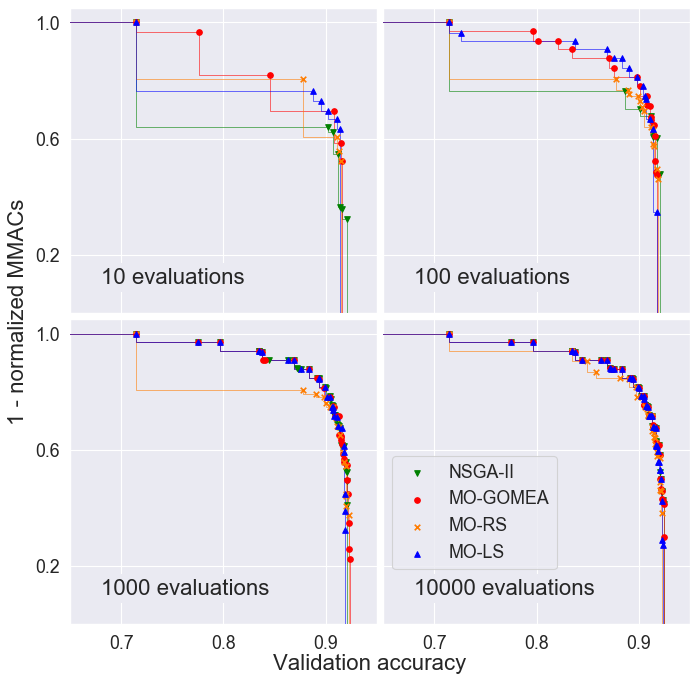

In [1098]:
initPlottingStuff(20, 16, 16)
def getFN(algorithm, run, ark):
    cifar = "cifar10" if ark is "ark8" else "cifar100"
    return "../data/bench_"+cifar+"_MO/" + algorithm + "_"+ark+"_"+cifar+"/MO_info" + str(run) + ".json"

def plotArchives(evals_lst, ark):
    cifar = "cifar10" if ark is "ark8" else "cifar100"
    rows = 2
    columns = 2
    fig, ax_lst = plt.subplots(rows, columns, figsize=(columns * 5, rows * 5), dpi=80, sharex=True, sharey=True)
    if rows is not 1 and columns is not 1:
        ax_lst = [item for row in ax_lst for item in row]
    
    for ax, evals in zip(ax_lst, evals_lst):
    
#         plotSearchSpace(ax, ark, 10000)
#         plotTruePareto(ax, ark)
        
        plot = "validation"
        plotArchive(ax, getFN("NSGA-II", 1, ark), evals, plot=plot, color=colors[0], marker="v", label="NSGA-II")
        plotArchive(ax, getFN("MO-GOMEA", 6, ark), evals, plot=plot, color=colors[1], marker="o", label="MO-GOMEA")
        plotArchive(ax, getFN("MO-RS", 0, ark), evals, plot=plot, color=colors[2], marker="x", label="MO-RS")
        plotArchive(ax, getFN("MO-LS", 5, ark), evals, plot=plot, color=colors[3], marker="^", label="MO-LS")

        ax.text(0.68, 0.1, str(evals) + " evaluations", fontsize=20, bbox=dict(facecolor=color_bg_default, edgecolor="none"))
        ax.set_xlim(0.65, 0.95)
        ax.set_ylim(0, 1.05)
            
    # Common axis labels
    fig.text(0.5, 0.06, 'Validation accuracy', ha='center', va='center', fontsize=20)
    fig.text(0.06, 0.5, '1 - normalized MMACs', ha='center', va='center', rotation='vertical', fontsize=20)
    
    ax_lst[2].xaxis.set_major_locator(plt.MaxNLocator(3))
    ax_lst[0].yaxis.set_major_locator(plt.FixedLocator([0.2, 0.6, 1.0]))
#     fig.text(0.5, 0.9, "Elitist archives at different points in time", ha='center', va='center', fontsize=20)
    
    ax_lst[3].legend(loc=3, bbox_to_anchor=(0, 0.15))
    
    spacing = 0.02
    plt.subplots_adjust(hspace=spacing, wspace=spacing)
    
#     fig.savefig('imgs/C10_MO_Pareto.png', dpi = 300, bbox_inches='tight')
#     fig.savefig('imgs/C10_MO_Pareto.pdf', dpi = 300, bbox_inches='tight', format='pdf')

plotArchives([10, 100, 1000, 10000], "ark8")
    


##### FINAL

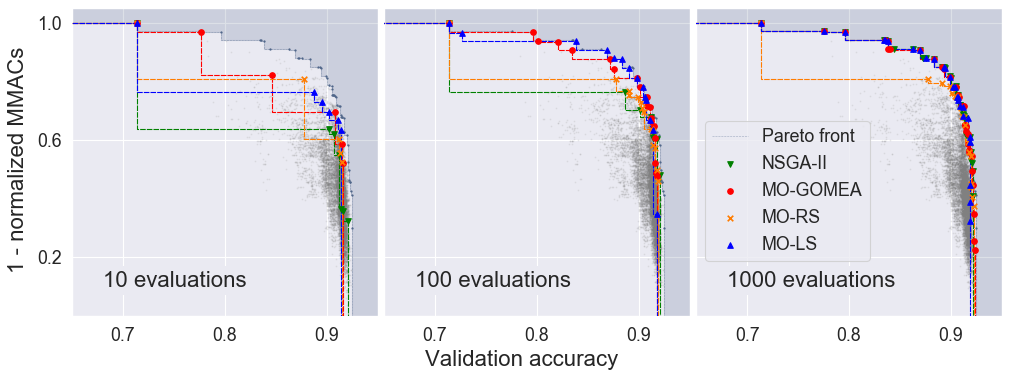

In [1155]:
initPlottingStuff(20, 16, 16)
def getFN(algorithm, run, ark):
    cifar = "cifar10" if ark is "ark8" else "cifar100"
    return "../data/bench_"+cifar+"_MO/" + algorithm + "_"+ark+"_"+cifar+"/MO_info" + str(run) + ".json"

def plotArchives(evals_lst, ark):
    cifar = "cifar10" if ark is "ark8" else "cifar100"
    rows = 1
    columns = 3
    fig, ax_lst = plt.subplots(rows, columns, figsize=(columns * 5, rows * 5), dpi=80, sharex=True, sharey=True)
    if rows is not 1 and columns is not 1:
        ax_lst = [item for row in ax_lst for item in row]
    
    for ax, evals in zip(ax_lst, evals_lst):
    
        plotSearchSpace(ax, ark, 10000)
        plotTruePareto(ax, ark)
        
        plot = "validation"
        plotArchive(ax, getFN("NSGA-II", 1, ark), evals, plot=plot, color=colors[0], marker="v", label="NSGA-II")
        plotArchive(ax, getFN("MO-GOMEA", 6, ark), evals, plot=plot, color=colors[1], marker="o", label="MO-GOMEA")
        plotArchive(ax, getFN("MO-RS", 0, ark), evals, plot=plot, color=colors[2], marker="x", label="MO-RS")
        plotArchive(ax, getFN("MO-LS", 5, ark), evals, plot=plot, color=colors[3], marker="^", label="MO-LS")

        ax.text(0.68, 0.1, str(evals) + " evaluations", fontsize=20, bbox=dict(facecolor=color_bg_default, edgecolor="none"))
        ax.set_xlim(0.65, 0.95)
        ax.set_ylim(0, 1.05)
            
    # Common axis labels
    fig.text(0.5, 0, 'Validation accuracy', ha='center', va='center', fontsize=20)
    fig.text(0.08, 0.5, '1 - normalized MMACs', ha='center', va='center', rotation='vertical', fontsize=20)
    
    ax_lst[2].xaxis.set_major_locator(plt.MaxNLocator(3))
    ax_lst[0].yaxis.set_major_locator(plt.FixedLocator([0.2, 0.6, 1.0]))    
    ax_lst[2].legend(loc=3, bbox_to_anchor=(0, 0.15))
    
    spacing = 0.02
    plt.subplots_adjust(hspace=spacing, wspace=spacing)
    
    fig.savefig('imgs/C10_MO_Pareto_val_1x3.png', dpi = 300, bbox_inches='tight')
    fig.savefig('imgs/C10_MO_Pareto_val_1x3.pdf', dpi = 300, bbox_inches='tight', format='pdf')

plotArchives([10, 100, 1000], "ark8")

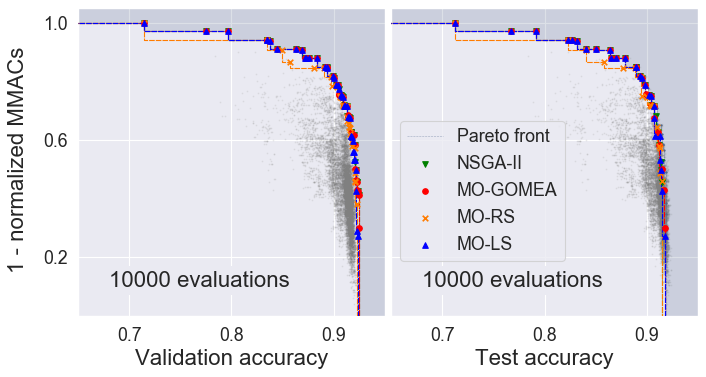

In [1154]:
initPlottingStuff(20, 16, 16)
def getFN(algorithm, run, ark):
    cifar = "cifar10" if ark is "ark8" else "cifar100"
    return "../data/bench_"+cifar+"_MO/" + algorithm + "_"+ark+"_"+cifar+"/MO_info" + str(run) + ".json"

def plotArchives(plot, ark):
    cifar = "cifar10" if ark is "ark8" else "cifar100"
    rows = 1
    columns = 2
    fig, ax_lst = plt.subplots(rows, columns, figsize=(columns * 5, rows * 5), dpi=80, sharex=True, sharey=True)
    if rows is not 1 and columns is not 1:
        ax_lst = [item for row in ax_lst for item in row]
    
    evals=10000
    for ax, plot in zip(ax_lst, plot):
    
        plotSearchSpace(ax, ark, 10000)
        plotTruePareto(ax, ark, plot=plot)
        
#         plot = "validation"
        plotArchive(ax, getFN("NSGA-II", 1, ark), evals, plot=plot, color=colors[0], marker="v", label="NSGA-II")
        plotArchive(ax, getFN("MO-GOMEA", 6, ark), evals, plot=plot, color=colors[1], marker="o", label="MO-GOMEA")
        plotArchive(ax, getFN("MO-RS", 0, ark), evals, plot=plot, color=colors[2], marker="x", label="MO-RS")
        plotArchive(ax, getFN("MO-LS", 5, ark), evals, plot=plot, color=colors[3], marker="^", label="MO-LS")

        ax.text(0.68, 0.1, str(evals) + " evaluations", fontsize=20, bbox=dict(facecolor=color_bg_default, edgecolor="none"))
        ax.set_xlim(0.65, 0.95)
        ax.set_ylim(0, 1.05)
            
    # Common axis labels
#     fig.text(0.5, 0, 'Validation accuracy', ha='center', va='center', fontsize=20)
    ax_lst[0].set_xlabel("Validation accuracy")
    ax_lst[1].set_xlabel("Test accuracy")
    fig.text(0.05, 0.5, '1 - normalized MMACs', ha='center', va='center', rotation='vertical', fontsize=20)
    
    ax_lst[0].xaxis.set_major_locator(plt.MaxNLocator(3))
    ax_lst[0].yaxis.set_major_locator(plt.FixedLocator([0.2, 0.6, 1.0]))    
    ax_lst[1].legend(loc=3, bbox_to_anchor=(0, 0.15))
    
    spacing = 0.02
    plt.subplots_adjust(hspace=spacing, wspace=spacing)
    
    fig.savefig('imgs/C10_MO_Pareto_valtest_1x2.png', dpi = 300, bbox_inches='tight')
    fig.savefig('imgs/C10_MO_Pareto_valtest_1x2.pdf', dpi = 300, bbox_inches='tight', format='pdf')

plotArchives(["validation", "test"], "ark8")

## Plotting archive (C100)

##### Initial

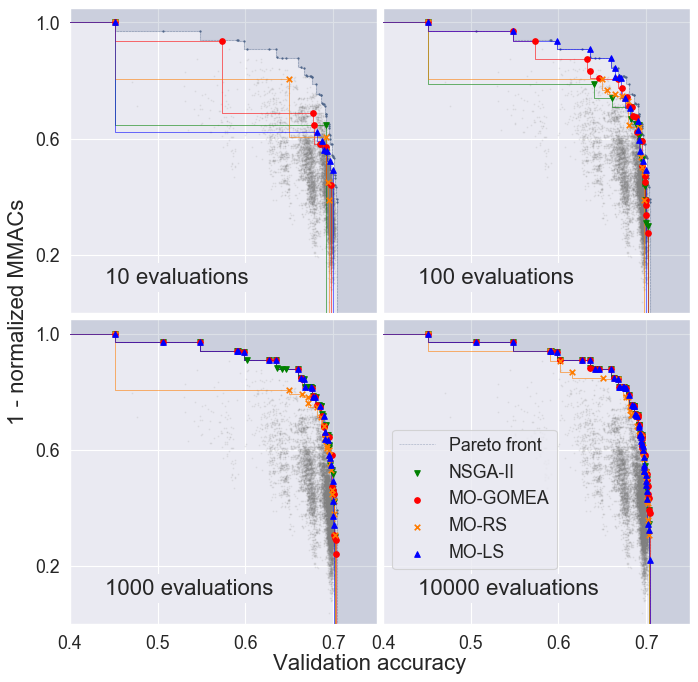

In [895]:
initPlottingStuff(20, 16, 16)
def getFN(algorithm, run, ark):
    cifar = "cifar10" if ark is "ark8" else "cifar100"
    return "../data/bench_"+cifar+"_MO/" + algorithm + "_"+ark+"_"+cifar+"/MO_info" + str(run) + ".json"

def plotArchives(evals_lst, ark):
    cifar = "cifar10" if ark is "ark8" else "cifar100"
    rows = 2
    columns = 2
    fig, ax_lst = plt.subplots(rows, columns, figsize=(columns * 5, rows * 5), dpi=80, sharex=True, sharey=True)
    if rows is not 1 and columns is not 1:
        ax_lst = [item for row in ax_lst for item in row]
    
    for ax, evals in zip(ax_lst, evals_lst):
    
        plotSearchSpace(ax, ark, 10000)
        plotTruePareto(ax, ark)

        plotArchive(ax, getFN("NSGA-II", 1, ark), evals, color=colors[0], marker="v", label="NSGA-II")
        plotArchive(ax, getFN("MO-GOMEA", 6, ark), evals, color=colors[1], marker="o", label="MO-GOMEA")
        plotArchive(ax, getFN("MO-RS", 0, ark), evals, color=colors[2], marker="x", label="MO-RS")
        plotArchive(ax, getFN("MO-LS", 11, ark), evals, color=colors[3], marker="^", label="MO-LS")

        ax.text(0.44, 0.1, str(evals) + " evaluations", fontsize=20, bbox=dict(facecolor=color_bg_default, edgecolor="none"))
        ax.set_xlim(0.4, 0.75)
        ax.set_ylim(0, 1.05)
    
    # Common axis labels
    fig.text(0.5, 0.06, 'Validation accuracy', ha='center', va='center', fontsize=20)
    fig.text(0.06, 0.5, '1 - normalized MMACs', ha='center', va='center', rotation='vertical', fontsize=20)
    
    ax_lst[2].xaxis.set_major_locator(plt.FixedLocator([0.4, 0.5, 0.6, 0.7]))
    ax_lst[0].yaxis.set_major_locator(plt.FixedLocator([0.2, 0.6, 1.0]))
#     fig.text(0.5, 0.9, "Elitist archives at different points in time", ha='center', va='center', fontsize=20)
    
    ax_lst[3].legend(loc=3, bbox_to_anchor=(0, 0.15))
    
    spacing = 0.02
    plt.subplots_adjust(hspace=spacing, wspace=spacing)
    
    fig.savefig('imgs/C100_MO_Pareto.png', dpi = 300, bbox_inches='tight')
    fig.savefig('imgs/C100_MO_Pareto.pdf', dpi = 300, bbox_inches='tight', format='pdf')

plotArchives([10, 100, 1000, 10000], "ark7")

##### FINAL

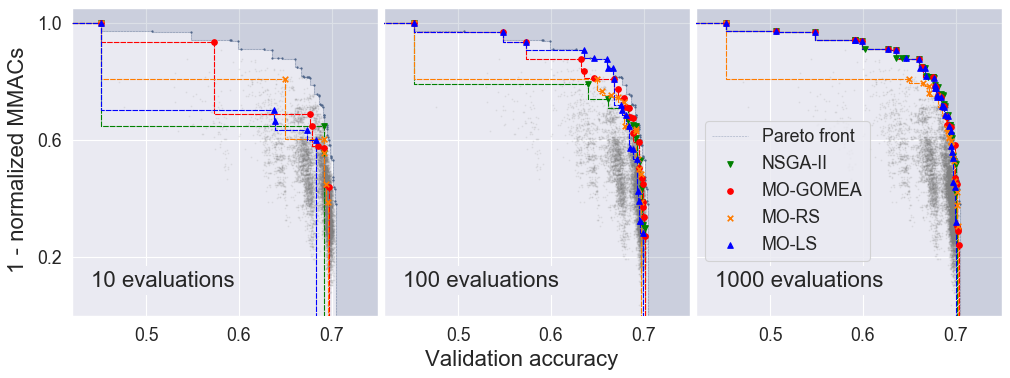

In [1156]:
initPlottingStuff(20, 16, 16)
def getFN(algorithm, run, ark):
    cifar = "cifar10" if ark is "ark8" else "cifar100"
    return "../data/bench_"+cifar+"_MO/" + algorithm + "_"+ark+"_"+cifar+"/MO_info" + str(run) + ".json"

def plotArchives(evals_lst, ark):
    cifar = "cifar10" if ark is "ark8" else "cifar100"
    rows = 1
    columns = 3
    fig, ax_lst = plt.subplots(rows, columns, figsize=(columns * 5, rows * 5), dpi=80, sharex=True, sharey=True)
    if rows is not 1 and columns is not 1:
        ax_lst = [item for row in ax_lst for item in row]
    
    for ax, evals in zip(ax_lst, evals_lst):
    
        plotSearchSpace(ax, ark, 10000)
        plotTruePareto(ax, ark)
        
        plot = "validation"
        plotArchive(ax, getFN("NSGA-II", 1, ark), evals, plot=plot, color=colors[0], marker="v", label="NSGA-II")
        plotArchive(ax, getFN("MO-GOMEA", 6, ark), evals, plot=plot, color=colors[1], marker="o", label="MO-GOMEA")
        plotArchive(ax, getFN("MO-RS", 0, ark), evals, plot=plot, color=colors[2], marker="x", label="MO-RS")
        plotArchive(ax, getFN("MO-LS", 5, ark), evals, plot=plot, color=colors[3], marker="^", label="MO-LS")

        ax.text(0.44, 0.1, str(evals) + " evaluations", fontsize=20, bbox=dict(facecolor=color_bg_default, edgecolor="none"))
        ax.set_xlim(0.42, 0.75)
        ax.set_ylim(0, 1.05)
            
    # Common axis labels
    fig.text(0.5, 0, 'Validation accuracy', ha='center', va='center', fontsize=20)
    fig.text(0.08, 0.5, '1 - normalized MMACs', ha='center', va='center', rotation='vertical', fontsize=20)
    
    ax_lst[2].xaxis.set_major_locator(plt.FixedLocator([0.4, 0.5, 0.6, 0.7]))
    ax_lst[0].yaxis.set_major_locator(plt.FixedLocator([0.2, 0.6, 1.0]))    
    ax_lst[2].legend(loc=3, bbox_to_anchor=(0, 0.15))
    
    spacing = 0.02
    plt.subplots_adjust(hspace=spacing, wspace=spacing)
    
    fig.savefig('imgs/C100_MO_Pareto_val_1x3.png', dpi = 300, bbox_inches='tight')
    fig.savefig('imgs/C100_MO_Pareto_val_1x3.pdf', dpi = 300, bbox_inches='tight', format='pdf')

plotArchives([10, 100, 1000], "ark7")

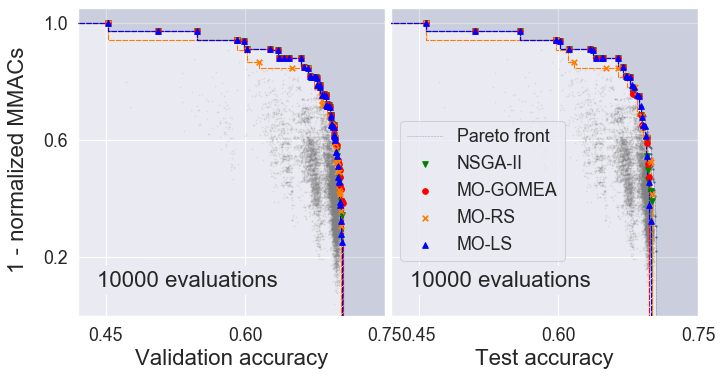

In [1157]:
initPlottingStuff(20, 16, 16)
def getFN(algorithm, run, ark):
    cifar = "cifar10" if ark is "ark8" else "cifar100"
    return "../data/bench_"+cifar+"_MO/" + algorithm + "_"+ark+"_"+cifar+"/MO_info" + str(run) + ".json"

def plotArchives(plot, ark):
    cifar = "cifar10" if ark is "ark8" else "cifar100"
    rows = 1
    columns = 2
    fig, ax_lst = plt.subplots(rows, columns, figsize=(columns * 5, rows * 5), dpi=80, sharex=True, sharey=True)
    if rows is not 1 and columns is not 1:
        ax_lst = [item for row in ax_lst for item in row]
    
    evals=10000
    for ax, plot in zip(ax_lst, plot):
    
        plotSearchSpace(ax, ark, 10000)
        plotTruePareto(ax, ark, plot)
        
#         plot = "validation"
        plotArchive(ax, getFN("NSGA-II", 1, ark), evals, cifar="c100", plot=plot, color=colors[0], marker="v", label="NSGA-II")
        plotArchive(ax, getFN("MO-GOMEA", 6, ark), evals, cifar="c100", plot=plot, color=colors[1], marker="o", label="MO-GOMEA")
        plotArchive(ax, getFN("MO-RS", 0, ark), evals, cifar="c100", plot=plot, color=colors[2], marker="x", label="MO-RS")
        plotArchive(ax, getFN("MO-LS", 5, ark), evals, cifar="c100", plot=plot, color=colors[3], marker="^", label="MO-LS")

        ax.text(0.44, 0.1, str(evals) + " evaluations", fontsize=20, bbox=dict(facecolor=color_bg_default, edgecolor="none"))
        ax.set_xlim(0.42, 0.75)
        ax.set_ylim(0, 1.05)
            
    # Common axis labels
#     fig.text(0.5, 0, 'Validation accuracy', ha='center', va='center', fontsize=20)
    ax_lst[0].set_xlabel("Validation accuracy")
    ax_lst[1].set_xlabel("Test accuracy")
    fig.text(0.05, 0.5, '1 - normalized MMACs', ha='center', va='center', rotation='vertical', fontsize=20)
    
    ax_lst[0].xaxis.set_major_locator(plt.MaxNLocator(3))
    ax_lst[0].yaxis.set_major_locator(plt.FixedLocator([0.2, 0.6, 1.0]))    
    ax_lst[1].legend(loc=3, bbox_to_anchor=(0, 0.15))
    
    spacing = 0.02
    plt.subplots_adjust(hspace=spacing, wspace=spacing)
    
    fig.savefig('imgs/C100_MO_Pareto_valtest_1x2.png', dpi = 300, bbox_inches='tight')
    fig.savefig('imgs/C100_MO_Pareto_valtest_1x2.pdf', dpi = 300, bbox_inches='tight', format='pdf')

plotArchives(["validation", "test"], "ark7")

In [87]:
with open("../../GA/benchmarks/ark7/pareto.json") as json_file:
    data = json.load(json_file)
    print(len(data['14']['fitness']))

51


# NAS101

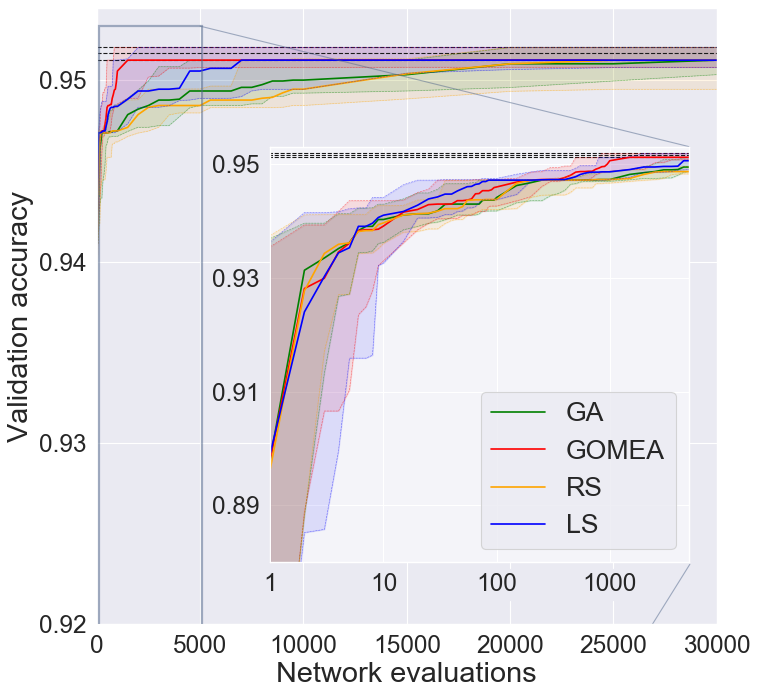

In [885]:
initPlottingStuff(26, 22, 24)
lst = ["../../GA-NASBench101/data/test_SimpleGA_pop100_2p",
       "../../GA-NASBench101/data/test_GOMEA_learned",
       "../../GA-NASBench101/data/test_RS", 
       "../../GA-NASBench101/data/test_LS"]

colors = ["green", "red", "orange", "blue"]

fig, ax1 = plt.subplots(1, 1, figsize=(10, 10), dpi=80)
ax2 = ax1.inset_axes([0.28, 0.1, 0.675, 0.675])
# ax3 = ax2.inset_axes([0.27, 0.1, 0.675, 0.675])

# axs = [ax1]
# for i in range(10):
#     ax = axs[i].inset_axes([0.27, 0.1, 0.7, 0.7])
#     axs.append(ax)


evalType = "network_unique_evals"
for j, algoRaw in enumerate(lst):
    algo = algoRaw.replace("../../GA-NASBench101/data/", '')
    
    algoLabel = algo.replace('_learned','') \
                    .replace('_pop100_2p','') \
                    .replace('test_','') \
                    .replace('Simple', '')

#     for i in range(len(axs)):
#         plottySO(axs[i], "../../GA-NASBench101/data/" + algo + "/", algoLabel, evalType, median=True, \
#                  percentile=25, minmax=False, forceGenerateSummaryFile=False, color=colors[j])
    plottySO(ax1, "../../GA-NASBench101/data/" + algo + "/", algoLabel, evalType, median=True, \
             percentile=25, minmax=False, forceGenerateSummaryFile=False, color=colors[j])
    plottySO(ax2, "../../GA-NASBench101/data/" + algo + "/", algoLabel, evalType, median=True, \
             percentile=25, minmax=False, forceGenerateSummaryFile=False, color=colors[j])

opt = [0.9518229, 0.9511218070983887, 0.9515224099159241]
ax1.hlines(opt, 0, 100000, linestyle='dashed', lw=1)
ax1.set_ylim(0.92, 0.954)
# ax[i].set_title("NAS-Bench-101: CIFAR-10")
ax1.set_xlabel("Network evaluations")
ax1.set_ylabel("Validation accuracy")
ax1.set_xlim(0, 30000)
# ax1.yaxis.set_major_locator(plt.FixedLocator([0.89, 0.91, 0.93, 0.95]))
ax1.yaxis.set_major_locator(plt.MultipleLocator(0.01))
ax1.xaxis.set_major_formatter(FormatStrFormatter('%d'))

ax2.hlines(opt, 0, 100000, linestyle='dashed', lw=1)
ax2.set_xlim(1, 5000)
ax2.set_ylim(0.88, 0.953)
ax2.set_xscale("log")
ax2.set_facecolor(color_bg_inset)
ax2.legend(loc=0)
ax2.yaxis.set_major_locator(plt.FixedLocator([0.89, 0.91, 0.93, 0.95]))
ax2.set_xticklabels(ax2.get_xticks(), backgroundcolor=color_bg_default)
ax2.set_yticklabels(ax2.get_yticks(), backgroundcolor=color_bg_default)
ax2.xaxis.set_major_formatter(FormatStrFormatter('%d'))

rect, connector_lines = ax1.indicate_inset_zoom(ax2, lw=2, edgecolor=color_zoom_border, alpha=0.5)
rect.set_x(100)
height = 0.035
rect.set_y(0.953 - height)
rect.set_height(height)
connector_lines[2].set_visible(False)
ax1.plot([5000, 28700], [0.88, 0.9233], lw=1, color=color_zoom_border, alpha=0.5)

fig.savefig('imgs/NAS101.png', dpi = 300, bbox_inches='tight')
fig.savefig('imgs/NAS101.pdf', dpi = 300, bbox_inches='tight', format='pdf')

# Output C100 30 test accuracy values (for significance test Marco)

In [1073]:
fn_lst = ["../data/bench_cifar100_SO/SimpleGAMut_pop100_2p_ark7_cifar100",
       "../data/bench_cifar100_SO/GOM_learned_ark7_cifar100",
       "../data/bench_cifar100_SO/RS_ark7_cifar100", 
       "../data/bench_cifar100_SO/LS_ark7_cifar100"]

reps = 30
outputjson = {}
algos = ["GA", "GOMEA", "RS", "LS"]
x = 0
for fn in fn_lst:
    genotypes = [""] * reps
    for i in range(reps):
        with open(fn+"/SO_info" + str(i) +".json") as json_file:
            data = json.load(json_file)
            data = data['changes_on_interval']['network_unique_evals']
            print(data['evals'][-1])
#             print(data['best_solution_genotype'][-1])
            genotypes[i] = data['best_solution_genotype'][-1]
            
    print(genotypes)
    print(getTestAcc(genotypes, benchmark_data_c100_raw))
    outputjson[algos[x]] = list(getTestAcc(genotypes, benchmark_data_c100_raw))
    x += 1
print(outputjson)

with open ("C100_testacc_100000evals_30runs.json", 'w') as json_file:
    json.dump(outputjson, json_file)

    


100000
100000
100000
100000
100000
100000
100000
100000
100000
100000
100000
100000
100000
100000
100000
100000
100000
100000
100000
100000
100000
100000
100000
100000
100000
100000
100000
100000
100000
100000
['22111111112220', '12122111112202', '12212022211121', '22112111212220', '12220211112220', '22111121112202', '12121122112202', '22222111112202', '12222110112220', '21121111212220', '22111111112202', '12122111112220', '22111111112220', '12211111112202', '12210212112222', '12121122112220', '21121111212202', '22111111112220', '12211111112202', '12222011112202', '12222110112220', '21121111212220', '21121111212202', '22222111112202', '12221122112202', '12222011112202', '12212112112222', '22222111112220', '12222211121211', '12122111112220']
[0.6929 0.6981 0.697  0.694  0.6977 0.6958 0.6954 0.6986 0.6977 0.6962
 0.6929 0.6981 0.6929 0.6937 0.6977 0.6954 0.6962 0.6929 0.6937 0.6977
 0.6977 0.6962 0.6962 0.6986 0.6965 0.6977 0.6992 0.6986 0.7001 0.6981]
100000
100000
100000
100000
100000


In [1075]:
with open("C100_testacc_100000evals_30runs.json") as json_file:
    data = json.load(json_file)
    GAdata = data["GA"]
    print(GAdata)

[0.6929000000000001, 0.6981, 0.6970000000000001, 0.6940000000000001, 0.6977, 0.6958, 0.6954000000000001, 0.6986, 0.6977, 0.6962, 0.6929000000000001, 0.6981, 0.6929000000000001, 0.6937000000000001, 0.6977, 0.6954000000000001, 0.6962, 0.6929000000000001, 0.6937000000000001, 0.6977, 0.6977, 0.6962, 0.6962, 0.6986, 0.6965000000000001, 0.6977, 0.6992, 0.6986, 0.7001000000000001, 0.6981]


# Scratch

In [1138]:
with open("../benchmarks/ark7/ark7_original.json") as json_file:
    data = json.load(json_file)
    print(list(data)[:10])

['I1I1221I121121', '12I22I1I22II22', '12I22I1I22II21', 'I1I1221I121122', '2II2II1II12I11', 'I1II1I1221III2', 'III211II121II1', 'III211II121II2', '222II21I2I2III', 'III2II2121II12']


In [1139]:
print(data["I1I1221I121121"])

{'test_acc': 69.18, 'MMACs': 128.38, 'val_acc': 69.42, 'Params': 2590372}
